In [1]:
from cc.env import make_env
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.train import (
    ModelControllerTrainer, 
    Tracker, make_dataloader, 
    UnsupervisedDataset
)
import jax.random as jrand
import optax
import jax.numpy as jnp
import equinox as eqx

/home/simon/miniforge3/envs/chain_control/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time_limit = 10.0
control_timestep = 0.01

env = make_env("two_segments_v1", time_limit=time_limit, control_timestep=control_timestep, random=1)

In [3]:
# make sure this definition matches exactly (!) the
# definition as it was used in notebook 3
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep,
    state_dim=50,
    f_depth=0, 
    u_transform=jnp.arctan
)

In [4]:
# trained in notebook 3
fitted_model = eqx.tree_deserialise_leaves("model.eqx", model)

# Training a controller

In [5]:
from cc.train import TrainingOptionsController
from cc.examples.neural_ode_controller_compact_example import make_neural_ode_controller
from cc.env.collect.collect import collect_random_step_source
from cc.env.wrappers import AddRefSignalRewardFnWrapper

source = collect_random_step_source(env, seeds=list(range(30)))
env_w_source = AddRefSignalRewardFnWrapper(env, source)

In [6]:
controller = make_neural_ode_controller(
    env_w_source.observation_spec(),
    env.action_spec(),
    env.control_timestep,
    5,
    f_depth=0
)

In [7]:
controller_dataloader = make_dataloader(
    UnsupervisedDataset(source.get_references_for_optimisation()),
    jrand.PRNGKey(1,),
    n_minibatches=5
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))

controller_train_options = TrainingOptionsController(
    controller_dataloader, optimizer, 
)

controller_trainer = ModelControllerTrainer(
    fitted_model, controller, controller_train_options=controller_train_options, 
    trackers=[Tracker("train_mse")]
)

In [8]:
controller_trainer.run(500)

  0%|                                                                                                                              | 0/500 [00:00<?, ?it/s]

train_loss:    27.1290 | train_mse:    27.1290 | :   0%|                                                                           | 0/500 [00:03<?, ?it/s]

train_loss:    27.1290 | train_mse:    27.1290 | :   0%|▏                                                                  | 1/500 [00:03<26:53,  3.23s/it]

train_loss:    21.3217 | train_mse:    21.3217 | :   0%|▏                                                                  | 1/500 [00:06<26:53,  3.23s/it]

train_loss:    21.3217 | train_mse:    21.3217 | :   0%|▎                                                                  | 2/500 [00:06<29:21,  3.54s/it]

train_loss:    18.2464 | train_mse:    18.2464 | :   0%|▎                                                                  | 2/500 [00:07<29:21,  3.54s/it]

train_loss:    18.2464 | train_mse:    18.2464 | :   1%|▍                                                                  | 3/500 [00:07<16:18,  1.97s/it]

train_loss:    15.7470 | train_mse:    15.7470 | :   1%|▍                                                                  | 3/500 [00:07<16:18,  1.97s/it]

train_loss:    15.7470 | train_mse:    15.7470 | :   1%|▌                                                                  | 4/500 [00:07<10:10,  1.23s/it]

train_loss:    13.4829 | train_mse:    13.4829 | :   1%|▌                                                                  | 4/500 [00:07<10:10,  1.23s/it]

train_loss:    11.5559 | train_mse:    11.5559 | :   1%|▌                                                                  | 4/500 [00:07<10:10,  1.23s/it]

train_loss:    11.5559 | train_mse:    11.5559 | :   1%|▊                                                                  | 6/500 [00:07<05:11,  1.59it/s]

train_loss:     9.7429 | train_mse:     9.7429 | :   1%|▊                                                                  | 6/500 [00:07<05:11,  1.59it/s]

train_loss:     9.7429 | train_mse:     9.7429 | :   1%|▉                                                                  | 7/500 [00:07<03:59,  2.06it/s]

train_loss:     8.2336 | train_mse:     8.2336 | :   1%|▉                                                                  | 7/500 [00:07<03:59,  2.06it/s]

train_loss:     8.2336 | train_mse:     8.2336 | :   2%|█                                                                  | 8/500 [00:07<03:06,  2.64it/s]

train_loss:     7.0585 | train_mse:     7.0585 | :   2%|█                                                                  | 8/500 [00:07<03:06,  2.64it/s]

train_loss:     7.0585 | train_mse:     7.0585 | :   2%|█▏                                                                 | 9/500 [00:07<02:26,  3.34it/s]

train_loss:     5.9430 | train_mse:     5.9430 | :   2%|█▏                                                                 | 9/500 [00:07<02:26,  3.34it/s]

train_loss:     5.1156 | train_mse:     5.1156 | :   2%|█▏                                                                 | 9/500 [00:07<02:26,  3.34it/s]

train_loss:     5.1156 | train_mse:     5.1156 | :   2%|█▍                                                                | 11/500 [00:07<01:42,  4.77it/s]

train_loss:     4.3854 | train_mse:     4.3854 | :   2%|█▍                                                                | 11/500 [00:07<01:42,  4.77it/s]

train_loss:     4.3854 | train_mse:     4.3854 | :   2%|█▌                                                                | 12/500 [00:07<01:29,  5.45it/s]

train_loss:     3.7863 | train_mse:     3.7863 | :   2%|█▌                                                                | 12/500 [00:08<01:29,  5.45it/s]

train_loss:     3.7863 | train_mse:     3.7863 | :   3%|█▋                                                                | 13/500 [00:08<01:18,  6.17it/s]

train_loss:     3.2985 | train_mse:     3.2985 | :   3%|█▋                                                                | 13/500 [00:08<01:18,  6.17it/s]

train_loss:     3.2985 | train_mse:     3.2985 | :   3%|█▊                                                                | 14/500 [00:08<01:11,  6.84it/s]

train_loss:     2.8373 | train_mse:     2.8373 | :   3%|█▊                                                                | 14/500 [00:08<01:11,  6.84it/s]

train_loss:     2.5094 | train_mse:     2.5094 | :   3%|█▊                                                                | 14/500 [00:08<01:11,  6.84it/s]

train_loss:     2.5094 | train_mse:     2.5094 | :   3%|██                                                                | 16/500 [00:08<01:01,  7.89it/s]

train_loss:     2.2408 | train_mse:     2.2408 | :   3%|██                                                                | 16/500 [00:08<01:01,  7.89it/s]

train_loss:     2.2408 | train_mse:     2.2408 | :   3%|██▏                                                               | 17/500 [00:08<01:01,  7.92it/s]

train_loss:     2.0537 | train_mse:     2.0537 | :   3%|██▏                                                               | 17/500 [00:08<01:01,  7.92it/s]

train_loss:     2.0537 | train_mse:     2.0537 | :   4%|██▍                                                               | 18/500 [00:08<00:57,  8.32it/s]

train_loss:     1.9155 | train_mse:     1.9155 | :   4%|██▍                                                               | 18/500 [00:08<00:57,  8.32it/s]

train_loss:     1.9155 | train_mse:     1.9155 | :   4%|██▌                                                               | 19/500 [00:08<00:55,  8.69it/s]

train_loss:     1.8154 | train_mse:     1.8154 | :   4%|██▌                                                               | 19/500 [00:08<00:55,  8.69it/s]

train_loss:     1.8154 | train_mse:     1.8154 | :   4%|██▋                                                               | 20/500 [00:08<00:53,  8.97it/s]

train_loss:     1.7404 | train_mse:     1.7404 | :   4%|██▋                                                               | 20/500 [00:08<00:53,  8.97it/s]

train_loss:     1.7404 | train_mse:     1.7404 | :   4%|██▊                                                               | 21/500 [00:08<00:52,  9.19it/s]

train_loss:     1.6602 | train_mse:     1.6602 | :   4%|██▊                                                               | 21/500 [00:09<00:52,  9.19it/s]

train_loss:     1.6602 | train_mse:     1.6602 | :   4%|██▉                                                               | 22/500 [00:09<00:51,  9.35it/s]

train_loss:     1.6013 | train_mse:     1.6013 | :   4%|██▉                                                               | 22/500 [00:09<00:51,  9.35it/s]

train_loss:     1.6013 | train_mse:     1.6013 | :   5%|███                                                               | 23/500 [00:09<00:50,  9.53it/s]

train_loss:     1.5370 | train_mse:     1.5370 | :   5%|███                                                               | 23/500 [00:09<00:50,  9.53it/s]

train_loss:     1.4685 | train_mse:     1.4685 | :   5%|███                                                               | 23/500 [00:09<00:50,  9.53it/s]

train_loss:     1.4685 | train_mse:     1.4685 | :   5%|███▎                                                              | 25/500 [00:09<00:48,  9.81it/s]

train_loss:     1.4267 | train_mse:     1.4267 | :   5%|███▎                                                              | 25/500 [00:09<00:48,  9.81it/s]

train_loss:     1.4338 | train_mse:     1.4338 | :   5%|███▎                                                              | 25/500 [00:09<00:48,  9.81it/s]

train_loss:     1.4338 | train_mse:     1.4338 | :   5%|███▌                                                              | 27/500 [00:09<00:47,  9.88it/s]

train_loss:     1.3651 | train_mse:     1.3651 | :   5%|███▌                                                              | 27/500 [00:09<00:47,  9.88it/s]

train_loss:     1.3651 | train_mse:     1.3651 | :   6%|███▋                                                              | 28/500 [00:09<00:47,  9.88it/s]

train_loss:     1.3341 | train_mse:     1.3341 | :   6%|███▋                                                              | 28/500 [00:09<00:47,  9.88it/s]

train_loss:     1.3341 | train_mse:     1.3341 | :   6%|███▊                                                              | 29/500 [00:09<00:47,  9.87it/s]

train_loss:     1.2914 | train_mse:     1.2914 | :   6%|███▊                                                              | 29/500 [00:09<00:47,  9.87it/s]

train_loss:     1.2914 | train_mse:     1.2914 | :   6%|███▉                                                              | 30/500 [00:09<00:47,  9.88it/s]

train_loss:     1.2620 | train_mse:     1.2620 | :   6%|███▉                                                              | 30/500 [00:09<00:47,  9.88it/s]

train_loss:     1.2620 | train_mse:     1.2620 | :   6%|████                                                              | 31/500 [00:09<00:47,  9.87it/s]

train_loss:     1.2570 | train_mse:     1.2570 | :   6%|████                                                              | 31/500 [00:10<00:47,  9.87it/s]

train_loss:     1.2570 | train_mse:     1.2570 | :   6%|████▏                                                             | 32/500 [00:10<00:47,  9.86it/s]

train_loss:     1.2252 | train_mse:     1.2252 | :   6%|████▏                                                             | 32/500 [00:10<00:47,  9.86it/s]

train_loss:     1.2252 | train_mse:     1.2252 | :   7%|████▎                                                             | 33/500 [00:10<00:47,  9.86it/s]

train_loss:     1.1976 | train_mse:     1.1976 | :   7%|████▎                                                             | 33/500 [00:10<00:47,  9.86it/s]

train_loss:     1.1976 | train_mse:     1.1976 | :   7%|████▍                                                             | 34/500 [00:10<00:47,  9.90it/s]

train_loss:     1.1858 | train_mse:     1.1858 | :   7%|████▍                                                             | 34/500 [00:10<00:47,  9.90it/s]

train_loss:     1.1858 | train_mse:     1.1858 | :   7%|████▌                                                             | 35/500 [00:10<00:47,  9.88it/s]

train_loss:     1.1636 | train_mse:     1.1636 | :   7%|████▌                                                             | 35/500 [00:10<00:47,  9.88it/s]

train_loss:     1.1292 | train_mse:     1.1292 | :   7%|████▌                                                             | 35/500 [00:10<00:47,  9.88it/s]

train_loss:     1.1292 | train_mse:     1.1292 | :   7%|████▉                                                             | 37/500 [00:10<00:46, 10.00it/s]

train_loss:     1.0988 | train_mse:     1.0988 | :   7%|████▉                                                             | 37/500 [00:10<00:46, 10.00it/s]

train_loss:     1.0834 | train_mse:     1.0834 | :   7%|████▉                                                             | 37/500 [00:10<00:46, 10.00it/s]

train_loss:     1.0834 | train_mse:     1.0834 | :   8%|█████▏                                                            | 39/500 [00:10<00:45, 10.04it/s]

train_loss:     1.0620 | train_mse:     1.0620 | :   8%|█████▏                                                            | 39/500 [00:10<00:45, 10.04it/s]

train_loss:     1.0544 | train_mse:     1.0544 | :   8%|█████▏                                                            | 39/500 [00:10<00:45, 10.04it/s]

train_loss:     1.0544 | train_mse:     1.0544 | :   8%|█████▍                                                            | 41/500 [00:10<00:45, 10.08it/s]

train_loss:     1.0436 | train_mse:     1.0436 | :   8%|█████▍                                                            | 41/500 [00:11<00:45, 10.08it/s]

train_loss:     1.0306 | train_mse:     1.0306 | :   8%|█████▍                                                            | 41/500 [00:11<00:45, 10.08it/s]

train_loss:     1.0306 | train_mse:     1.0306 | :   9%|█████▋                                                            | 43/500 [00:11<00:45, 10.09it/s]

train_loss:     1.0204 | train_mse:     1.0204 | :   9%|█████▋                                                            | 43/500 [00:11<00:45, 10.09it/s]

train_loss:     1.0095 | train_mse:     1.0095 | :   9%|█████▋                                                            | 43/500 [00:11<00:45, 10.09it/s]

train_loss:     1.0095 | train_mse:     1.0095 | :   9%|█████▉                                                            | 45/500 [00:11<00:45, 10.11it/s]

train_loss:     0.9952 | train_mse:     0.9952 | :   9%|█████▉                                                            | 45/500 [00:11<00:45, 10.11it/s]

train_loss:     0.9794 | train_mse:     0.9794 | :   9%|█████▉                                                            | 45/500 [00:11<00:45, 10.11it/s]

train_loss:     0.9794 | train_mse:     0.9794 | :   9%|██████▏                                                           | 47/500 [00:11<00:44, 10.10it/s]

train_loss:     0.9698 | train_mse:     0.9698 | :   9%|██████▏                                                           | 47/500 [00:11<00:44, 10.10it/s]

train_loss:     0.9982 | train_mse:     0.9982 | :   9%|██████▏                                                           | 47/500 [00:11<00:44, 10.10it/s]

train_loss:     0.9982 | train_mse:     0.9982 | :  10%|██████▍                                                           | 49/500 [00:11<00:45,  9.99it/s]

train_loss:     0.9717 | train_mse:     0.9717 | :  10%|██████▍                                                           | 49/500 [00:11<00:45,  9.99it/s]

train_loss:     0.9717 | train_mse:     0.9717 | :  10%|██████▌                                                           | 50/500 [00:11<00:45,  9.96it/s]

train_loss:     0.9631 | train_mse:     0.9631 | :  10%|██████▌                                                           | 50/500 [00:11<00:45,  9.96it/s]

train_loss:     0.9631 | train_mse:     0.9631 | :  10%|██████▋                                                           | 51/500 [00:11<00:45,  9.95it/s]

train_loss:     0.9500 | train_mse:     0.9500 | :  10%|██████▋                                                           | 51/500 [00:12<00:45,  9.95it/s]

train_loss:     0.9500 | train_mse:     0.9500 | :  10%|██████▊                                                           | 52/500 [00:12<00:45,  9.95it/s]

train_loss:     0.9277 | train_mse:     0.9277 | :  10%|██████▊                                                           | 52/500 [00:12<00:45,  9.95it/s]

train_loss:     0.9277 | train_mse:     0.9277 | :  11%|██████▉                                                           | 53/500 [00:12<00:45,  9.91it/s]

train_loss:     0.9300 | train_mse:     0.9300 | :  11%|██████▉                                                           | 53/500 [00:12<00:45,  9.91it/s]

train_loss:     0.9300 | train_mse:     0.9300 | :  11%|███████▏                                                          | 54/500 [00:12<00:45,  9.81it/s]

train_loss:     0.9206 | train_mse:     0.9206 | :  11%|███████▏                                                          | 54/500 [00:12<00:45,  9.81it/s]

train_loss:     0.9206 | train_mse:     0.9206 | :  11%|███████▎                                                          | 55/500 [00:12<00:45,  9.68it/s]

train_loss:     0.9100 | train_mse:     0.9100 | :  11%|███████▎                                                          | 55/500 [00:12<00:45,  9.68it/s]

train_loss:     0.9100 | train_mse:     0.9100 | :  11%|███████▍                                                          | 56/500 [00:12<00:46,  9.58it/s]

train_loss:     0.9055 | train_mse:     0.9055 | :  11%|███████▍                                                          | 56/500 [00:12<00:46,  9.58it/s]

train_loss:     0.9055 | train_mse:     0.9055 | :  11%|███████▌                                                          | 57/500 [00:12<00:46,  9.44it/s]

train_loss:     0.9035 | train_mse:     0.9035 | :  11%|███████▌                                                          | 57/500 [00:12<00:46,  9.44it/s]

train_loss:     0.9035 | train_mse:     0.9035 | :  12%|███████▋                                                          | 58/500 [00:12<00:47,  9.28it/s]

train_loss:     0.8925 | train_mse:     0.8925 | :  12%|███████▋                                                          | 58/500 [00:12<00:47,  9.28it/s]

train_loss:     0.8925 | train_mse:     0.8925 | :  12%|███████▊                                                          | 59/500 [00:12<00:48,  9.15it/s]

train_loss:     0.8783 | train_mse:     0.8783 | :  12%|███████▊                                                          | 59/500 [00:12<00:48,  9.15it/s]

train_loss:     0.8783 | train_mse:     0.8783 | :  12%|███████▉                                                          | 60/500 [00:12<00:48,  9.14it/s]

train_loss:     0.8719 | train_mse:     0.8719 | :  12%|███████▉                                                          | 60/500 [00:13<00:48,  9.14it/s]

train_loss:     0.8719 | train_mse:     0.8719 | :  12%|████████                                                          | 61/500 [00:13<00:47,  9.16it/s]

train_loss:     0.8690 | train_mse:     0.8690 | :  12%|████████                                                          | 61/500 [00:13<00:47,  9.16it/s]

train_loss:     0.8690 | train_mse:     0.8690 | :  12%|████████▏                                                         | 62/500 [00:13<00:47,  9.22it/s]

train_loss:     0.8707 | train_mse:     0.8707 | :  12%|████████▏                                                         | 62/500 [00:13<00:47,  9.22it/s]

train_loss:     0.8707 | train_mse:     0.8707 | :  13%|████████▎                                                         | 63/500 [00:13<00:46,  9.33it/s]

train_loss:     0.8625 | train_mse:     0.8625 | :  13%|████████▎                                                         | 63/500 [00:13<00:46,  9.33it/s]

train_loss:     0.8625 | train_mse:     0.8625 | :  13%|████████▍                                                         | 64/500 [00:13<00:46,  9.40it/s]

train_loss:     0.8535 | train_mse:     0.8535 | :  13%|████████▍                                                         | 64/500 [00:13<00:46,  9.40it/s]

train_loss:     0.8535 | train_mse:     0.8535 | :  13%|████████▌                                                         | 65/500 [00:13<00:46,  9.44it/s]

train_loss:     0.8434 | train_mse:     0.8434 | :  13%|████████▌                                                         | 65/500 [00:13<00:46,  9.44it/s]

train_loss:     0.8434 | train_mse:     0.8434 | :  13%|████████▋                                                         | 66/500 [00:13<00:45,  9.49it/s]

train_loss:     0.8364 | train_mse:     0.8364 | :  13%|████████▋                                                         | 66/500 [00:13<00:45,  9.49it/s]

train_loss:     0.8364 | train_mse:     0.8364 | :  13%|████████▊                                                         | 67/500 [00:13<00:45,  9.51it/s]

train_loss:     0.8301 | train_mse:     0.8301 | :  13%|████████▊                                                         | 67/500 [00:13<00:45,  9.51it/s]

train_loss:     0.8301 | train_mse:     0.8301 | :  14%|████████▉                                                         | 68/500 [00:13<00:45,  9.57it/s]

train_loss:     0.8246 | train_mse:     0.8246 | :  14%|████████▉                                                         | 68/500 [00:13<00:45,  9.57it/s]

train_loss:     0.8246 | train_mse:     0.8246 | :  14%|█████████                                                         | 69/500 [00:13<00:44,  9.65it/s]

train_loss:     0.8191 | train_mse:     0.8191 | :  14%|█████████                                                         | 69/500 [00:13<00:44,  9.65it/s]

train_loss:     0.8191 | train_mse:     0.8191 | :  14%|█████████▏                                                        | 70/500 [00:13<00:44,  9.61it/s]

train_loss:     0.8128 | train_mse:     0.8128 | :  14%|█████████▏                                                        | 70/500 [00:14<00:44,  9.61it/s]

train_loss:     0.8128 | train_mse:     0.8128 | :  14%|█████████▎                                                        | 71/500 [00:14<00:44,  9.62it/s]

train_loss:     0.8298 | train_mse:     0.8298 | :  14%|█████████▎                                                        | 71/500 [00:14<00:44,  9.62it/s]

train_loss:     0.8298 | train_mse:     0.8298 | :  14%|█████████▌                                                        | 72/500 [00:14<00:44,  9.66it/s]

train_loss:     0.8151 | train_mse:     0.8151 | :  14%|█████████▌                                                        | 72/500 [00:14<00:44,  9.66it/s]

train_loss:     0.8151 | train_mse:     0.8151 | :  15%|█████████▋                                                        | 73/500 [00:14<00:44,  9.70it/s]

train_loss:     0.8055 | train_mse:     0.8055 | :  15%|█████████▋                                                        | 73/500 [00:14<00:44,  9.70it/s]

train_loss:     0.8055 | train_mse:     0.8055 | :  15%|█████████▊                                                        | 74/500 [00:14<00:44,  9.51it/s]

train_loss:     0.8065 | train_mse:     0.8065 | :  15%|█████████▊                                                        | 74/500 [00:14<00:44,  9.51it/s]

train_loss:     0.8065 | train_mse:     0.8065 | :  15%|█████████▉                                                        | 75/500 [00:14<00:49,  8.59it/s]

train_loss:     0.8038 | train_mse:     0.8038 | :  15%|█████████▉                                                        | 75/500 [00:14<00:49,  8.59it/s]

train_loss:     0.8038 | train_mse:     0.8038 | :  15%|██████████                                                        | 76/500 [00:14<00:50,  8.40it/s]

train_loss:     0.8024 | train_mse:     0.8024 | :  15%|██████████                                                        | 76/500 [00:14<00:50,  8.40it/s]

train_loss:     0.8024 | train_mse:     0.8024 | :  15%|██████████▏                                                       | 77/500 [00:14<00:51,  8.28it/s]

train_loss:     0.8123 | train_mse:     0.8123 | :  15%|██████████▏                                                       | 77/500 [00:14<00:51,  8.28it/s]

train_loss:     0.8123 | train_mse:     0.8123 | :  16%|██████████▎                                                       | 78/500 [00:14<00:51,  8.18it/s]

train_loss:     0.7991 | train_mse:     0.7991 | :  16%|██████████▎                                                       | 78/500 [00:15<00:51,  8.18it/s]

train_loss:     0.7991 | train_mse:     0.7991 | :  16%|██████████▍                                                       | 79/500 [00:15<00:51,  8.21it/s]

train_loss:     0.7924 | train_mse:     0.7924 | :  16%|██████████▍                                                       | 79/500 [00:15<00:51,  8.21it/s]

train_loss:     0.7924 | train_mse:     0.7924 | :  16%|██████████▌                                                       | 80/500 [00:15<00:50,  8.32it/s]

train_loss:     0.8021 | train_mse:     0.8021 | :  16%|██████████▌                                                       | 80/500 [00:15<00:50,  8.32it/s]

train_loss:     0.8021 | train_mse:     0.8021 | :  16%|██████████▋                                                       | 81/500 [00:15<00:49,  8.43it/s]

train_loss:     0.8055 | train_mse:     0.8055 | :  16%|██████████▋                                                       | 81/500 [00:15<00:49,  8.43it/s]

train_loss:     0.8055 | train_mse:     0.8055 | :  16%|██████████▊                                                       | 82/500 [00:15<00:48,  8.57it/s]

train_loss:     0.8321 | train_mse:     0.8321 | :  16%|██████████▊                                                       | 82/500 [00:15<00:48,  8.57it/s]

train_loss:     0.8321 | train_mse:     0.8321 | :  17%|██████████▉                                                       | 83/500 [00:15<00:48,  8.67it/s]

train_loss:     0.7874 | train_mse:     0.7874 | :  17%|██████████▉                                                       | 83/500 [00:15<00:48,  8.67it/s]

train_loss:     0.7874 | train_mse:     0.7874 | :  17%|███████████                                                       | 84/500 [00:15<00:47,  8.76it/s]

train_loss:     0.7885 | train_mse:     0.7885 | :  17%|███████████                                                       | 84/500 [00:15<00:47,  8.76it/s]

train_loss:     0.7885 | train_mse:     0.7885 | :  17%|███████████▏                                                      | 85/500 [00:15<00:46,  8.85it/s]

train_loss:     0.7998 | train_mse:     0.7998 | :  17%|███████████▏                                                      | 85/500 [00:15<00:46,  8.85it/s]

train_loss:     0.7998 | train_mse:     0.7998 | :  17%|███████████▎                                                      | 86/500 [00:15<00:46,  8.96it/s]

train_loss:     0.7852 | train_mse:     0.7852 | :  17%|███████████▎                                                      | 86/500 [00:15<00:46,  8.96it/s]

train_loss:     0.7852 | train_mse:     0.7852 | :  17%|███████████▍                                                      | 87/500 [00:15<00:45,  9.10it/s]

train_loss:     0.7816 | train_mse:     0.7816 | :  17%|███████████▍                                                      | 87/500 [00:16<00:45,  9.10it/s]

train_loss:     0.7816 | train_mse:     0.7816 | :  18%|███████████▌                                                      | 88/500 [00:16<00:44,  9.23it/s]

train_loss:     0.7815 | train_mse:     0.7815 | :  18%|███████████▌                                                      | 88/500 [00:16<00:44,  9.23it/s]

train_loss:     0.7815 | train_mse:     0.7815 | :  18%|███████████▋                                                      | 89/500 [00:16<00:44,  9.33it/s]

train_loss:     0.7837 | train_mse:     0.7837 | :  18%|███████████▋                                                      | 89/500 [00:16<00:44,  9.33it/s]

train_loss:     0.7837 | train_mse:     0.7837 | :  18%|███████████▉                                                      | 90/500 [00:16<00:43,  9.39it/s]

train_loss:     0.7793 | train_mse:     0.7793 | :  18%|███████████▉                                                      | 90/500 [00:16<00:43,  9.39it/s]

train_loss:     0.7793 | train_mse:     0.7793 | :  18%|████████████                                                      | 91/500 [00:16<00:43,  9.46it/s]

train_loss:     0.7756 | train_mse:     0.7756 | :  18%|████████████                                                      | 91/500 [00:16<00:43,  9.46it/s]

train_loss:     0.7756 | train_mse:     0.7756 | :  18%|████████████▏                                                     | 92/500 [00:16<00:42,  9.49it/s]

train_loss:     0.7842 | train_mse:     0.7842 | :  18%|████████████▏                                                     | 92/500 [00:16<00:42,  9.49it/s]

train_loss:     0.7842 | train_mse:     0.7842 | :  19%|████████████▎                                                     | 93/500 [00:16<00:42,  9.53it/s]

train_loss:     0.7820 | train_mse:     0.7820 | :  19%|████████████▎                                                     | 93/500 [00:16<00:42,  9.53it/s]

train_loss:     0.7820 | train_mse:     0.7820 | :  19%|████████████▍                                                     | 94/500 [00:16<00:42,  9.62it/s]

train_loss:     0.7746 | train_mse:     0.7746 | :  19%|████████████▍                                                     | 94/500 [00:16<00:42,  9.62it/s]

train_loss:     0.7746 | train_mse:     0.7746 | :  19%|████████████▌                                                     | 95/500 [00:16<00:41,  9.67it/s]

train_loss:     0.7759 | train_mse:     0.7759 | :  19%|████████████▌                                                     | 95/500 [00:16<00:41,  9.67it/s]

train_loss:     0.7759 | train_mse:     0.7759 | :  19%|████████████▋                                                     | 96/500 [00:16<00:41,  9.72it/s]

train_loss:     0.7720 | train_mse:     0.7720 | :  19%|████████████▋                                                     | 96/500 [00:16<00:41,  9.72it/s]

train_loss:     0.7720 | train_mse:     0.7720 | :  19%|████████████▊                                                     | 97/500 [00:16<00:41,  9.74it/s]

train_loss:     0.7731 | train_mse:     0.7731 | :  19%|████████████▊                                                     | 97/500 [00:17<00:41,  9.74it/s]

train_loss:     0.7731 | train_mse:     0.7731 | :  20%|████████████▉                                                     | 98/500 [00:17<00:41,  9.80it/s]

train_loss:     0.7764 | train_mse:     0.7764 | :  20%|████████████▉                                                     | 98/500 [00:17<00:41,  9.80it/s]

train_loss:     0.7764 | train_mse:     0.7764 | :  20%|█████████████                                                     | 99/500 [00:17<00:40,  9.81it/s]

train_loss:     0.7957 | train_mse:     0.7957 | :  20%|█████████████                                                     | 99/500 [00:17<00:40,  9.81it/s]

train_loss:     0.7764 | train_mse:     0.7764 | :  20%|█████████████                                                     | 99/500 [00:17<00:40,  9.81it/s]

train_loss:     0.7764 | train_mse:     0.7764 | :  20%|█████████████▏                                                   | 101/500 [00:17<00:40,  9.86it/s]

train_loss:     0.7779 | train_mse:     0.7779 | :  20%|█████████████▏                                                   | 101/500 [00:17<00:40,  9.86it/s]

train_loss:     0.7779 | train_mse:     0.7779 | :  20%|█████████████▎                                                   | 102/500 [00:17<00:40,  9.89it/s]

train_loss:     0.7721 | train_mse:     0.7721 | :  20%|█████████████▎                                                   | 102/500 [00:17<00:40,  9.89it/s]

train_loss:     0.7721 | train_mse:     0.7721 | :  21%|█████████████▍                                                   | 103/500 [00:17<00:40,  9.86it/s]

train_loss:     0.7920 | train_mse:     0.7920 | :  21%|█████████████▍                                                   | 103/500 [00:17<00:40,  9.86it/s]

train_loss:     0.7829 | train_mse:     0.7829 | :  21%|█████████████▍                                                   | 103/500 [00:17<00:40,  9.86it/s]

train_loss:     0.7829 | train_mse:     0.7829 | :  21%|█████████████▋                                                   | 105/500 [00:17<00:39,  9.91it/s]

train_loss:     0.7813 | train_mse:     0.7813 | :  21%|█████████████▋                                                   | 105/500 [00:17<00:39,  9.91it/s]

train_loss:     0.7813 | train_mse:     0.7813 | :  21%|█████████████▊                                                   | 106/500 [00:17<00:39,  9.92it/s]

train_loss:     0.7782 | train_mse:     0.7782 | :  21%|█████████████▊                                                   | 106/500 [00:17<00:39,  9.92it/s]

train_loss:     0.7782 | train_mse:     0.7782 | :  21%|█████████████▉                                                   | 107/500 [00:17<00:39,  9.86it/s]

train_loss:     0.7820 | train_mse:     0.7820 | :  21%|█████████████▉                                                   | 107/500 [00:18<00:39,  9.86it/s]

train_loss:     0.7820 | train_mse:     0.7820 | :  22%|██████████████                                                   | 108/500 [00:18<00:39,  9.81it/s]

train_loss:     0.7877 | train_mse:     0.7877 | :  22%|██████████████                                                   | 108/500 [00:18<00:39,  9.81it/s]

train_loss:     0.7877 | train_mse:     0.7877 | :  22%|██████████████▏                                                  | 109/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7874 | train_mse:     0.7874 | :  22%|██████████████▏                                                  | 109/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7874 | train_mse:     0.7874 | :  22%|██████████████▎                                                  | 110/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7907 | train_mse:     0.7907 | :  22%|██████████████▎                                                  | 110/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7907 | train_mse:     0.7907 | :  22%|██████████████▍                                                  | 111/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7787 | train_mse:     0.7787 | :  22%|██████████████▍                                                  | 111/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7787 | train_mse:     0.7787 | :  22%|██████████████▌                                                  | 112/500 [00:18<00:39,  9.79it/s]

train_loss:     0.7760 | train_mse:     0.7760 | :  22%|██████████████▌                                                  | 112/500 [00:18<00:39,  9.79it/s]

train_loss:     0.7760 | train_mse:     0.7760 | :  23%|██████████████▋                                                  | 113/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7877 | train_mse:     0.7877 | :  23%|██████████████▋                                                  | 113/500 [00:18<00:39,  9.80it/s]

train_loss:     0.7877 | train_mse:     0.7877 | :  23%|██████████████▊                                                  | 114/500 [00:18<00:39,  9.80it/s]

train_loss:     0.8211 | train_mse:     0.8211 | :  23%|██████████████▊                                                  | 114/500 [00:18<00:39,  9.80it/s]

train_loss:     0.8211 | train_mse:     0.8211 | :  23%|██████████████▉                                                  | 115/500 [00:18<00:39,  9.83it/s]

train_loss:     0.7942 | train_mse:     0.7942 | :  23%|██████████████▉                                                  | 115/500 [00:18<00:39,  9.83it/s]

train_loss:     0.7942 | train_mse:     0.7942 | :  23%|███████████████                                                  | 116/500 [00:18<00:38,  9.85it/s]

train_loss:     0.7657 | train_mse:     0.7657 | :  23%|███████████████                                                  | 116/500 [00:18<00:38,  9.85it/s]

train_loss:     0.7657 | train_mse:     0.7657 | :  23%|███████████████▏                                                 | 117/500 [00:18<00:38,  9.83it/s]

train_loss:     0.7675 | train_mse:     0.7675 | :  23%|███████████████▏                                                 | 117/500 [00:19<00:38,  9.83it/s]

train_loss:     0.7675 | train_mse:     0.7675 | :  24%|███████████████▎                                                 | 118/500 [00:19<00:38,  9.83it/s]

train_loss:     0.7751 | train_mse:     0.7751 | :  24%|███████████████▎                                                 | 118/500 [00:19<00:38,  9.83it/s]

train_loss:     0.7751 | train_mse:     0.7751 | :  24%|███████████████▍                                                 | 119/500 [00:19<00:38,  9.83it/s]

train_loss:     0.7794 | train_mse:     0.7794 | :  24%|███████████████▍                                                 | 119/500 [00:19<00:38,  9.83it/s]

train_loss:     0.7794 | train_mse:     0.7794 | :  24%|███████████████▌                                                 | 120/500 [00:19<00:38,  9.86it/s]

train_loss:     0.7722 | train_mse:     0.7722 | :  24%|███████████████▌                                                 | 120/500 [00:19<00:38,  9.86it/s]

train_loss:     0.7722 | train_mse:     0.7722 | :  24%|███████████████▋                                                 | 121/500 [00:19<00:38,  9.85it/s]

train_loss:     0.7861 | train_mse:     0.7861 | :  24%|███████████████▋                                                 | 121/500 [00:19<00:38,  9.85it/s]

train_loss:     0.7861 | train_mse:     0.7861 | :  24%|███████████████▊                                                 | 122/500 [00:19<00:38,  9.85it/s]

train_loss:     0.7981 | train_mse:     0.7981 | :  24%|███████████████▊                                                 | 122/500 [00:19<00:38,  9.85it/s]

train_loss:     0.7981 | train_mse:     0.7981 | :  25%|███████████████▉                                                 | 123/500 [00:19<00:38,  9.83it/s]

train_loss:     0.7996 | train_mse:     0.7996 | :  25%|███████████████▉                                                 | 123/500 [00:19<00:38,  9.83it/s]

train_loss:     0.7996 | train_mse:     0.7996 | :  25%|████████████████                                                 | 124/500 [00:19<00:38,  9.76it/s]

train_loss:     0.7708 | train_mse:     0.7708 | :  25%|████████████████                                                 | 124/500 [00:19<00:38,  9.76it/s]

train_loss:     0.7708 | train_mse:     0.7708 | :  25%|████████████████▎                                                | 125/500 [00:19<00:38,  9.69it/s]

train_loss:     0.7758 | train_mse:     0.7758 | :  25%|████████████████▎                                                | 125/500 [00:19<00:38,  9.69it/s]

train_loss:     0.7758 | train_mse:     0.7758 | :  25%|████████████████▍                                                | 126/500 [00:19<00:38,  9.71it/s]

train_loss:     0.7797 | train_mse:     0.7797 | :  25%|████████████████▍                                                | 126/500 [00:19<00:38,  9.71it/s]

train_loss:     0.7797 | train_mse:     0.7797 | :  25%|████████████████▌                                                | 127/500 [00:19<00:38,  9.73it/s]

train_loss:     0.7709 | train_mse:     0.7709 | :  25%|████████████████▌                                                | 127/500 [00:20<00:38,  9.73it/s]

train_loss:     0.7709 | train_mse:     0.7709 | :  26%|████████████████▋                                                | 128/500 [00:20<00:38,  9.74it/s]

train_loss:     0.7726 | train_mse:     0.7726 | :  26%|████████████████▋                                                | 128/500 [00:20<00:38,  9.74it/s]

train_loss:     0.7726 | train_mse:     0.7726 | :  26%|████████████████▊                                                | 129/500 [00:20<00:38,  9.74it/s]

train_loss:     0.7828 | train_mse:     0.7828 | :  26%|████████████████▊                                                | 129/500 [00:20<00:38,  9.74it/s]

train_loss:     0.7828 | train_mse:     0.7828 | :  26%|████████████████▉                                                | 130/500 [00:20<00:37,  9.77it/s]

train_loss:     0.8237 | train_mse:     0.8237 | :  26%|████████████████▉                                                | 130/500 [00:20<00:37,  9.77it/s]

train_loss:     0.8237 | train_mse:     0.8237 | :  26%|█████████████████                                                | 131/500 [00:20<00:37,  9.78it/s]

train_loss:     0.8142 | train_mse:     0.8142 | :  26%|█████████████████                                                | 131/500 [00:20<00:37,  9.78it/s]

train_loss:     0.8142 | train_mse:     0.8142 | :  26%|█████████████████▏                                               | 132/500 [00:20<00:37,  9.79it/s]

train_loss:     0.7843 | train_mse:     0.7843 | :  26%|█████████████████▏                                               | 132/500 [00:20<00:37,  9.79it/s]

train_loss:     0.7843 | train_mse:     0.7843 | :  27%|█████████████████▎                                               | 133/500 [00:20<00:37,  9.81it/s]

train_loss:     0.8080 | train_mse:     0.8080 | :  27%|█████████████████▎                                               | 133/500 [00:20<00:37,  9.81it/s]

train_loss:     0.8080 | train_mse:     0.8080 | :  27%|█████████████████▍                                               | 134/500 [00:20<00:37,  9.79it/s]

train_loss:     0.8148 | train_mse:     0.8148 | :  27%|█████████████████▍                                               | 134/500 [00:20<00:37,  9.79it/s]

train_loss:     0.8148 | train_mse:     0.8148 | :  27%|█████████████████▌                                               | 135/500 [00:20<00:37,  9.79it/s]

train_loss:     0.7808 | train_mse:     0.7808 | :  27%|█████████████████▌                                               | 135/500 [00:20<00:37,  9.79it/s]

train_loss:     0.7808 | train_mse:     0.7808 | :  27%|█████████████████▋                                               | 136/500 [00:20<00:37,  9.80it/s]

train_loss:     0.7726 | train_mse:     0.7726 | :  27%|█████████████████▋                                               | 136/500 [00:21<00:37,  9.80it/s]

train_loss:     0.7726 | train_mse:     0.7726 | :  27%|█████████████████▊                                               | 137/500 [00:21<00:37,  9.79it/s]

train_loss:     0.7673 | train_mse:     0.7673 | :  27%|█████████████████▊                                               | 137/500 [00:21<00:37,  9.79it/s]

train_loss:     0.7673 | train_mse:     0.7673 | :  28%|█████████████████▉                                               | 138/500 [00:21<00:36,  9.82it/s]

train_loss:     0.7715 | train_mse:     0.7715 | :  28%|█████████████████▉                                               | 138/500 [00:21<00:36,  9.82it/s]

train_loss:     0.7715 | train_mse:     0.7715 | :  28%|██████████████████                                               | 139/500 [00:21<00:36,  9.86it/s]

train_loss:     0.7730 | train_mse:     0.7730 | :  28%|██████████████████                                               | 139/500 [00:21<00:36,  9.86it/s]

train_loss:     0.7730 | train_mse:     0.7730 | :  28%|██████████████████▏                                              | 140/500 [00:21<00:36,  9.86it/s]

train_loss:     0.7601 | train_mse:     0.7601 | :  28%|██████████████████▏                                              | 140/500 [00:21<00:36,  9.86it/s]

train_loss:     0.7601 | train_mse:     0.7601 | :  28%|██████████████████▎                                              | 141/500 [00:21<00:36,  9.85it/s]

train_loss:     0.7661 | train_mse:     0.7661 | :  28%|██████████████████▎                                              | 141/500 [00:21<00:36,  9.85it/s]

train_loss:     0.7661 | train_mse:     0.7661 | :  28%|██████████████████▍                                              | 142/500 [00:21<00:36,  9.81it/s]

train_loss:     0.7697 | train_mse:     0.7697 | :  28%|██████████████████▍                                              | 142/500 [00:21<00:36,  9.81it/s]

train_loss:     0.7697 | train_mse:     0.7697 | :  29%|██████████████████▌                                              | 143/500 [00:21<00:36,  9.79it/s]

train_loss:     0.7609 | train_mse:     0.7609 | :  29%|██████████████████▌                                              | 143/500 [00:21<00:36,  9.79it/s]

train_loss:     0.7609 | train_mse:     0.7609 | :  29%|██████████████████▋                                              | 144/500 [00:21<00:36,  9.78it/s]

train_loss:     0.7690 | train_mse:     0.7690 | :  29%|██████████████████▋                                              | 144/500 [00:21<00:36,  9.78it/s]

train_loss:     0.7690 | train_mse:     0.7690 | :  29%|██████████████████▊                                              | 145/500 [00:21<00:36,  9.77it/s]

train_loss:     0.8183 | train_mse:     0.8183 | :  29%|██████████████████▊                                              | 145/500 [00:21<00:36,  9.77it/s]

train_loss:     0.8183 | train_mse:     0.8183 | :  29%|██████████████████▉                                              | 146/500 [00:21<00:36,  9.76it/s]

train_loss:     0.7955 | train_mse:     0.7955 | :  29%|██████████████████▉                                              | 146/500 [00:22<00:36,  9.76it/s]

train_loss:     0.7955 | train_mse:     0.7955 | :  29%|███████████████████                                              | 147/500 [00:22<00:36,  9.77it/s]

train_loss:     0.7700 | train_mse:     0.7700 | :  29%|███████████████████                                              | 147/500 [00:22<00:36,  9.77it/s]

train_loss:     0.7700 | train_mse:     0.7700 | :  30%|███████████████████▏                                             | 148/500 [00:22<00:35,  9.80it/s]

train_loss:     0.7553 | train_mse:     0.7553 | :  30%|███████████████████▏                                             | 148/500 [00:22<00:35,  9.80it/s]

train_loss:     0.7553 | train_mse:     0.7553 | :  30%|███████████████████▎                                             | 149/500 [00:22<00:35,  9.82it/s]

train_loss:     0.7599 | train_mse:     0.7599 | :  30%|███████████████████▎                                             | 149/500 [00:22<00:35,  9.82it/s]

train_loss:     0.7599 | train_mse:     0.7599 | :  30%|███████████████████▌                                             | 150/500 [00:22<00:35,  9.81it/s]

train_loss:     0.7549 | train_mse:     0.7549 | :  30%|███████████████████▌                                             | 150/500 [00:22<00:35,  9.81it/s]

train_loss:     0.7549 | train_mse:     0.7549 | :  30%|███████████████████▋                                             | 151/500 [00:22<00:35,  9.81it/s]

train_loss:     0.7657 | train_mse:     0.7657 | :  30%|███████████████████▋                                             | 151/500 [00:22<00:35,  9.81it/s]

train_loss:     0.7657 | train_mse:     0.7657 | :  30%|███████████████████▊                                             | 152/500 [00:22<00:35,  9.80it/s]

train_loss:     0.7705 | train_mse:     0.7705 | :  30%|███████████████████▊                                             | 152/500 [00:22<00:35,  9.80it/s]

train_loss:     0.7705 | train_mse:     0.7705 | :  31%|███████████████████▉                                             | 153/500 [00:22<00:35,  9.83it/s]

train_loss:     0.7675 | train_mse:     0.7675 | :  31%|███████████████████▉                                             | 153/500 [00:22<00:35,  9.83it/s]

train_loss:     0.7675 | train_mse:     0.7675 | :  31%|████████████████████                                             | 154/500 [00:22<00:35,  9.82it/s]

train_loss:     0.7653 | train_mse:     0.7653 | :  31%|████████████████████                                             | 154/500 [00:22<00:35,  9.82it/s]

train_loss:     0.7653 | train_mse:     0.7653 | :  31%|████████████████████▏                                            | 155/500 [00:22<00:35,  9.83it/s]

train_loss:     0.7629 | train_mse:     0.7629 | :  31%|████████████████████▏                                            | 155/500 [00:22<00:35,  9.83it/s]

train_loss:     0.7629 | train_mse:     0.7629 | :  31%|████████████████████▎                                            | 156/500 [00:22<00:35,  9.82it/s]

train_loss:     0.7706 | train_mse:     0.7706 | :  31%|████████████████████▎                                            | 156/500 [00:23<00:35,  9.82it/s]

train_loss:     0.7706 | train_mse:     0.7706 | :  31%|████████████████████▍                                            | 157/500 [00:23<00:34,  9.83it/s]

train_loss:     0.7772 | train_mse:     0.7772 | :  31%|████████████████████▍                                            | 157/500 [00:23<00:34,  9.83it/s]

train_loss:     0.7772 | train_mse:     0.7772 | :  32%|████████████████████▌                                            | 158/500 [00:23<00:34,  9.84it/s]

train_loss:     0.7659 | train_mse:     0.7659 | :  32%|████████████████████▌                                            | 158/500 [00:23<00:34,  9.84it/s]

train_loss:     0.7659 | train_mse:     0.7659 | :  32%|████████████████████▋                                            | 159/500 [00:23<00:34,  9.84it/s]

train_loss:     0.7616 | train_mse:     0.7616 | :  32%|████████████████████▋                                            | 159/500 [00:23<00:34,  9.84it/s]

train_loss:     0.7616 | train_mse:     0.7616 | :  32%|████████████████████▊                                            | 160/500 [00:23<00:34,  9.80it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  32%|████████████████████▊                                            | 160/500 [00:23<00:34,  9.80it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  32%|████████████████████▉                                            | 161/500 [00:23<00:34,  9.79it/s]

train_loss:     0.7773 | train_mse:     0.7773 | :  32%|████████████████████▉                                            | 161/500 [00:23<00:34,  9.79it/s]

train_loss:     0.7773 | train_mse:     0.7773 | :  32%|█████████████████████                                            | 162/500 [00:23<00:34,  9.77it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  32%|█████████████████████                                            | 162/500 [00:23<00:34,  9.77it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  33%|█████████████████████▏                                           | 163/500 [00:23<00:34,  9.76it/s]

train_loss:     0.7721 | train_mse:     0.7721 | :  33%|█████████████████████▏                                           | 163/500 [00:23<00:34,  9.76it/s]

train_loss:     0.7721 | train_mse:     0.7721 | :  33%|█████████████████████▎                                           | 164/500 [00:23<00:34,  9.78it/s]

train_loss:     0.7635 | train_mse:     0.7635 | :  33%|█████████████████████▎                                           | 164/500 [00:23<00:34,  9.78it/s]

train_loss:     0.7635 | train_mse:     0.7635 | :  33%|█████████████████████▍                                           | 165/500 [00:23<00:34,  9.79it/s]

train_loss:     0.7537 | train_mse:     0.7537 | :  33%|█████████████████████▍                                           | 165/500 [00:23<00:34,  9.79it/s]

train_loss:     0.7537 | train_mse:     0.7537 | :  33%|█████████████████████▌                                           | 166/500 [00:23<00:34,  9.79it/s]

train_loss:     0.7561 | train_mse:     0.7561 | :  33%|█████████████████████▌                                           | 166/500 [00:24<00:34,  9.79it/s]

train_loss:     0.7561 | train_mse:     0.7561 | :  33%|█████████████████████▋                                           | 167/500 [00:24<00:33,  9.81it/s]

train_loss:     0.7486 | train_mse:     0.7486 | :  33%|█████████████████████▋                                           | 167/500 [00:24<00:33,  9.81it/s]

train_loss:     0.7486 | train_mse:     0.7486 | :  34%|█████████████████████▊                                           | 168/500 [00:24<00:33,  9.81it/s]

train_loss:     0.7501 | train_mse:     0.7501 | :  34%|█████████████████████▊                                           | 168/500 [00:24<00:33,  9.81it/s]

train_loss:     0.7501 | train_mse:     0.7501 | :  34%|█████████████████████▉                                           | 169/500 [00:24<00:33,  9.80it/s]

train_loss:     0.7575 | train_mse:     0.7575 | :  34%|█████████████████████▉                                           | 169/500 [00:24<00:33,  9.80it/s]

train_loss:     0.7575 | train_mse:     0.7575 | :  34%|██████████████████████                                           | 170/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7677 | train_mse:     0.7677 | :  34%|██████████████████████                                           | 170/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7677 | train_mse:     0.7677 | :  34%|██████████████████████▏                                          | 171/500 [00:24<00:33,  9.81it/s]

train_loss:     0.7580 | train_mse:     0.7580 | :  34%|██████████████████████▏                                          | 171/500 [00:24<00:33,  9.81it/s]

train_loss:     0.7580 | train_mse:     0.7580 | :  34%|██████████████████████▎                                          | 172/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7602 | train_mse:     0.7602 | :  34%|██████████████████████▎                                          | 172/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7602 | train_mse:     0.7602 | :  35%|██████████████████████▍                                          | 173/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7688 | train_mse:     0.7688 | :  35%|██████████████████████▍                                          | 173/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7688 | train_mse:     0.7688 | :  35%|██████████████████████▌                                          | 174/500 [00:24<00:33,  9.83it/s]

train_loss:     0.7559 | train_mse:     0.7559 | :  35%|██████████████████████▌                                          | 174/500 [00:24<00:33,  9.83it/s]

train_loss:     0.7559 | train_mse:     0.7559 | :  35%|██████████████████████▊                                          | 175/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7457 | train_mse:     0.7457 | :  35%|██████████████████████▊                                          | 175/500 [00:24<00:33,  9.82it/s]

train_loss:     0.7457 | train_mse:     0.7457 | :  35%|██████████████████████▉                                          | 176/500 [00:24<00:32,  9.83it/s]

train_loss:     0.7513 | train_mse:     0.7513 | :  35%|██████████████████████▉                                          | 176/500 [00:25<00:32,  9.83it/s]

train_loss:     0.7513 | train_mse:     0.7513 | :  35%|███████████████████████                                          | 177/500 [00:25<00:32,  9.82it/s]

train_loss:     0.7480 | train_mse:     0.7480 | :  35%|███████████████████████                                          | 177/500 [00:25<00:32,  9.82it/s]

train_loss:     0.7480 | train_mse:     0.7480 | :  36%|███████████████████████▏                                         | 178/500 [00:25<00:32,  9.77it/s]

train_loss:     0.7491 | train_mse:     0.7491 | :  36%|███████████████████████▏                                         | 178/500 [00:25<00:32,  9.77it/s]

train_loss:     0.7491 | train_mse:     0.7491 | :  36%|███████████████████████▎                                         | 179/500 [00:25<00:32,  9.76it/s]

train_loss:     0.7414 | train_mse:     0.7414 | :  36%|███████████████████████▎                                         | 179/500 [00:25<00:32,  9.76it/s]

train_loss:     0.7414 | train_mse:     0.7414 | :  36%|███████████████████████▍                                         | 180/500 [00:25<00:32,  9.77it/s]

train_loss:     0.7432 | train_mse:     0.7432 | :  36%|███████████████████████▍                                         | 180/500 [00:25<00:32,  9.77it/s]

train_loss:     0.7432 | train_mse:     0.7432 | :  36%|███████████████████████▌                                         | 181/500 [00:25<00:32,  9.75it/s]

train_loss:     0.7408 | train_mse:     0.7408 | :  36%|███████████████████████▌                                         | 181/500 [00:25<00:32,  9.75it/s]

train_loss:     0.7408 | train_mse:     0.7408 | :  36%|███████████████████████▋                                         | 182/500 [00:25<00:32,  9.75it/s]

train_loss:     0.7532 | train_mse:     0.7532 | :  36%|███████████████████████▋                                         | 182/500 [00:25<00:32,  9.75it/s]

train_loss:     0.7532 | train_mse:     0.7532 | :  37%|███████████████████████▊                                         | 183/500 [00:25<00:32,  9.76it/s]

train_loss:     0.7534 | train_mse:     0.7534 | :  37%|███████████████████████▊                                         | 183/500 [00:25<00:32,  9.76it/s]

train_loss:     0.7534 | train_mse:     0.7534 | :  37%|███████████████████████▉                                         | 184/500 [00:25<00:32,  9.75it/s]

train_loss:     0.7604 | train_mse:     0.7604 | :  37%|███████████████████████▉                                         | 184/500 [00:25<00:32,  9.75it/s]

train_loss:     0.7604 | train_mse:     0.7604 | :  37%|████████████████████████                                         | 185/500 [00:25<00:32,  9.75it/s]

train_loss:     0.7428 | train_mse:     0.7428 | :  37%|████████████████████████                                         | 185/500 [00:26<00:32,  9.75it/s]

train_loss:     0.7428 | train_mse:     0.7428 | :  37%|████████████████████████▏                                        | 186/500 [00:26<00:32,  9.77it/s]

train_loss:     0.7420 | train_mse:     0.7420 | :  37%|████████████████████████▏                                        | 186/500 [00:26<00:32,  9.77it/s]

train_loss:     0.7420 | train_mse:     0.7420 | :  37%|████████████████████████▎                                        | 187/500 [00:26<00:31,  9.81it/s]

train_loss:     0.7503 | train_mse:     0.7503 | :  37%|████████████████████████▎                                        | 187/500 [00:26<00:31,  9.81it/s]

train_loss:     0.7503 | train_mse:     0.7503 | :  38%|████████████████████████▍                                        | 188/500 [00:26<00:31,  9.81it/s]

train_loss:     0.7551 | train_mse:     0.7551 | :  38%|████████████████████████▍                                        | 188/500 [00:26<00:31,  9.81it/s]

train_loss:     0.7551 | train_mse:     0.7551 | :  38%|████████████████████████▌                                        | 189/500 [00:26<00:31,  9.84it/s]

train_loss:     0.7815 | train_mse:     0.7815 | :  38%|████████████████████████▌                                        | 189/500 [00:26<00:31,  9.84it/s]

train_loss:     0.7815 | train_mse:     0.7815 | :  38%|████████████████████████▋                                        | 190/500 [00:26<00:31,  9.83it/s]

train_loss:     0.8018 | train_mse:     0.8018 | :  38%|████████████████████████▋                                        | 190/500 [00:26<00:31,  9.83it/s]

train_loss:     0.8018 | train_mse:     0.8018 | :  38%|████████████████████████▊                                        | 191/500 [00:26<00:31,  9.83it/s]

train_loss:     0.7757 | train_mse:     0.7757 | :  38%|████████████████████████▊                                        | 191/500 [00:26<00:31,  9.83it/s]

train_loss:     0.7757 | train_mse:     0.7757 | :  38%|████████████████████████▉                                        | 192/500 [00:26<00:31,  9.84it/s]

train_loss:     0.7604 | train_mse:     0.7604 | :  38%|████████████████████████▉                                        | 192/500 [00:26<00:31,  9.84it/s]

train_loss:     0.7604 | train_mse:     0.7604 | :  39%|█████████████████████████                                        | 193/500 [00:26<00:31,  9.85it/s]

train_loss:     0.7875 | train_mse:     0.7875 | :  39%|█████████████████████████                                        | 193/500 [00:26<00:31,  9.85it/s]

train_loss:     0.7875 | train_mse:     0.7875 | :  39%|█████████████████████████▏                                       | 194/500 [00:26<00:31,  9.82it/s]

train_loss:     0.7617 | train_mse:     0.7617 | :  39%|█████████████████████████▏                                       | 194/500 [00:26<00:31,  9.82it/s]

train_loss:     0.7617 | train_mse:     0.7617 | :  39%|█████████████████████████▎                                       | 195/500 [00:26<00:31,  9.76it/s]

train_loss:     0.8050 | train_mse:     0.8050 | :  39%|█████████████████████████▎                                       | 195/500 [00:27<00:31,  9.76it/s]

train_loss:     0.8050 | train_mse:     0.8050 | :  39%|█████████████████████████▍                                       | 196/500 [00:27<00:31,  9.72it/s]

train_loss:     0.8619 | train_mse:     0.8619 | :  39%|█████████████████████████▍                                       | 196/500 [00:27<00:31,  9.72it/s]

train_loss:     0.8619 | train_mse:     0.8619 | :  39%|█████████████████████████▌                                       | 197/500 [00:27<00:31,  9.73it/s]

train_loss:     0.8165 | train_mse:     0.8165 | :  39%|█████████████████████████▌                                       | 197/500 [00:27<00:31,  9.73it/s]

train_loss:     0.8165 | train_mse:     0.8165 | :  40%|█████████████████████████▋                                       | 198/500 [00:27<00:30,  9.75it/s]

train_loss:     0.7837 | train_mse:     0.7837 | :  40%|█████████████████████████▋                                       | 198/500 [00:27<00:30,  9.75it/s]

train_loss:     0.7837 | train_mse:     0.7837 | :  40%|█████████████████████████▊                                       | 199/500 [00:27<00:30,  9.83it/s]

train_loss:     0.7847 | train_mse:     0.7847 | :  40%|█████████████████████████▊                                       | 199/500 [00:27<00:30,  9.83it/s]

train_loss:     0.7847 | train_mse:     0.7847 | :  40%|██████████████████████████                                       | 200/500 [00:27<00:30,  9.84it/s]

train_loss:     0.8077 | train_mse:     0.8077 | :  40%|██████████████████████████                                       | 200/500 [00:27<00:30,  9.84it/s]

train_loss:     0.8077 | train_mse:     0.8077 | :  40%|██████████████████████████▏                                      | 201/500 [00:27<00:30,  9.80it/s]

train_loss:     0.7900 | train_mse:     0.7900 | :  40%|██████████████████████████▏                                      | 201/500 [00:27<00:30,  9.80it/s]

train_loss:     0.7900 | train_mse:     0.7900 | :  40%|██████████████████████████▎                                      | 202/500 [00:27<00:30,  9.74it/s]

train_loss:     0.7602 | train_mse:     0.7602 | :  40%|██████████████████████████▎                                      | 202/500 [00:27<00:30,  9.74it/s]

train_loss:     0.7602 | train_mse:     0.7602 | :  41%|██████████████████████████▍                                      | 203/500 [00:27<00:30,  9.77it/s]

train_loss:     0.7513 | train_mse:     0.7513 | :  41%|██████████████████████████▍                                      | 203/500 [00:27<00:30,  9.77it/s]

train_loss:     0.7513 | train_mse:     0.7513 | :  41%|██████████████████████████▌                                      | 204/500 [00:27<00:30,  9.76it/s]

train_loss:     0.7534 | train_mse:     0.7534 | :  41%|██████████████████████████▌                                      | 204/500 [00:27<00:30,  9.76it/s]

train_loss:     0.7534 | train_mse:     0.7534 | :  41%|██████████████████████████▋                                      | 205/500 [00:27<00:30,  9.78it/s]

train_loss:     0.7625 | train_mse:     0.7625 | :  41%|██████████████████████████▋                                      | 205/500 [00:28<00:30,  9.78it/s]

train_loss:     0.7625 | train_mse:     0.7625 | :  41%|██████████████████████████▊                                      | 206/500 [00:28<00:30,  9.79it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  41%|██████████████████████████▊                                      | 206/500 [00:28<00:30,  9.79it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  41%|██████████████████████████▉                                      | 207/500 [00:28<00:30,  9.70it/s]

train_loss:     0.7485 | train_mse:     0.7485 | :  41%|██████████████████████████▉                                      | 207/500 [00:28<00:30,  9.70it/s]

train_loss:     0.7485 | train_mse:     0.7485 | :  42%|███████████████████████████                                      | 208/500 [00:28<00:30,  9.57it/s]

train_loss:     0.7488 | train_mse:     0.7488 | :  42%|███████████████████████████                                      | 208/500 [00:28<00:30,  9.57it/s]

train_loss:     0.7488 | train_mse:     0.7488 | :  42%|███████████████████████████▏                                     | 209/500 [00:28<00:30,  9.46it/s]

train_loss:     0.8367 | train_mse:     0.8367 | :  42%|███████████████████████████▏                                     | 209/500 [00:28<00:30,  9.46it/s]

train_loss:     0.8367 | train_mse:     0.8367 | :  42%|███████████████████████████▎                                     | 210/500 [00:28<00:30,  9.40it/s]

train_loss:     0.8312 | train_mse:     0.8312 | :  42%|███████████████████████████▎                                     | 210/500 [00:28<00:30,  9.40it/s]

train_loss:     0.8312 | train_mse:     0.8312 | :  42%|███████████████████████████▍                                     | 211/500 [00:28<00:30,  9.33it/s]

train_loss:     0.7847 | train_mse:     0.7847 | :  42%|███████████████████████████▍                                     | 211/500 [00:28<00:30,  9.33it/s]

train_loss:     0.7847 | train_mse:     0.7847 | :  42%|███████████████████████████▌                                     | 212/500 [00:28<00:31,  9.28it/s]

train_loss:     0.7568 | train_mse:     0.7568 | :  42%|███████████████████████████▌                                     | 212/500 [00:28<00:31,  9.28it/s]

train_loss:     0.7568 | train_mse:     0.7568 | :  43%|███████████████████████████▋                                     | 213/500 [00:28<00:31,  9.21it/s]

train_loss:     0.7745 | train_mse:     0.7745 | :  43%|███████████████████████████▋                                     | 213/500 [00:28<00:31,  9.21it/s]

train_loss:     0.7745 | train_mse:     0.7745 | :  43%|███████████████████████████▊                                     | 214/500 [00:28<00:31,  9.22it/s]

train_loss:     0.7628 | train_mse:     0.7628 | :  43%|███████████████████████████▊                                     | 214/500 [00:29<00:31,  9.22it/s]

train_loss:     0.7628 | train_mse:     0.7628 | :  43%|███████████████████████████▉                                     | 215/500 [00:29<00:30,  9.28it/s]

train_loss:     0.7507 | train_mse:     0.7507 | :  43%|███████████████████████████▉                                     | 215/500 [00:29<00:30,  9.28it/s]

train_loss:     0.7507 | train_mse:     0.7507 | :  43%|████████████████████████████                                     | 216/500 [00:29<00:30,  9.38it/s]

train_loss:     0.7551 | train_mse:     0.7551 | :  43%|████████████████████████████                                     | 216/500 [00:29<00:30,  9.38it/s]

train_loss:     0.7551 | train_mse:     0.7551 | :  43%|████████████████████████████▏                                    | 217/500 [00:29<00:29,  9.51it/s]

train_loss:     0.7337 | train_mse:     0.7337 | :  43%|████████████████████████████▏                                    | 217/500 [00:29<00:29,  9.51it/s]

train_loss:     0.7337 | train_mse:     0.7337 | :  44%|████████████████████████████▎                                    | 218/500 [00:29<00:29,  9.60it/s]

train_loss:     0.7466 | train_mse:     0.7466 | :  44%|████████████████████████████▎                                    | 218/500 [00:29<00:29,  9.60it/s]

train_loss:     0.7466 | train_mse:     0.7466 | :  44%|████████████████████████████▍                                    | 219/500 [00:29<00:29,  9.67it/s]

train_loss:     0.7374 | train_mse:     0.7374 | :  44%|████████████████████████████▍                                    | 219/500 [00:29<00:29,  9.67it/s]

train_loss:     0.7443 | train_mse:     0.7443 | :  44%|████████████████████████████▍                                    | 219/500 [00:29<00:29,  9.67it/s]

train_loss:     0.7443 | train_mse:     0.7443 | :  44%|████████████████████████████▋                                    | 221/500 [00:29<00:28,  9.84it/s]

train_loss:     0.7418 | train_mse:     0.7418 | :  44%|████████████████████████████▋                                    | 221/500 [00:29<00:28,  9.84it/s]

train_loss:     0.7418 | train_mse:     0.7418 | :  44%|████████████████████████████▊                                    | 222/500 [00:29<00:28,  9.86it/s]

train_loss:     0.7335 | train_mse:     0.7335 | :  44%|████████████████████████████▊                                    | 222/500 [00:29<00:28,  9.86it/s]

train_loss:     0.7335 | train_mse:     0.7335 | :  45%|████████████████████████████▉                                    | 223/500 [00:29<00:27,  9.90it/s]

train_loss:     0.7429 | train_mse:     0.7429 | :  45%|████████████████████████████▉                                    | 223/500 [00:29<00:27,  9.90it/s]

train_loss:     0.7429 | train_mse:     0.7429 | :  45%|█████████████████████████████                                    | 224/500 [00:29<00:27,  9.89it/s]

train_loss:     0.7439 | train_mse:     0.7439 | :  45%|█████████████████████████████                                    | 224/500 [00:30<00:27,  9.89it/s]

train_loss:     0.7388 | train_mse:     0.7388 | :  45%|█████████████████████████████                                    | 224/500 [00:30<00:27,  9.89it/s]

train_loss:     0.7388 | train_mse:     0.7388 | :  45%|█████████████████████████████▍                                   | 226/500 [00:30<00:28,  9.69it/s]

train_loss:     0.7519 | train_mse:     0.7519 | :  45%|█████████████████████████████▍                                   | 226/500 [00:30<00:28,  9.69it/s]

train_loss:     0.7519 | train_mse:     0.7519 | :  45%|█████████████████████████████▌                                   | 227/500 [00:30<00:28,  9.51it/s]

train_loss:     0.7345 | train_mse:     0.7345 | :  45%|█████████████████████████████▌                                   | 227/500 [00:30<00:28,  9.51it/s]

train_loss:     0.7345 | train_mse:     0.7345 | :  46%|█████████████████████████████▋                                   | 228/500 [00:30<00:28,  9.48it/s]

train_loss:     0.7567 | train_mse:     0.7567 | :  46%|█████████████████████████████▋                                   | 228/500 [00:30<00:28,  9.48it/s]

train_loss:     0.7567 | train_mse:     0.7567 | :  46%|█████████████████████████████▊                                   | 229/500 [00:30<00:28,  9.43it/s]

train_loss:     0.7653 | train_mse:     0.7653 | :  46%|█████████████████████████████▊                                   | 229/500 [00:30<00:28,  9.43it/s]

train_loss:     0.7653 | train_mse:     0.7653 | :  46%|█████████████████████████████▉                                   | 230/500 [00:30<00:28,  9.39it/s]

train_loss:     0.7935 | train_mse:     0.7935 | :  46%|█████████████████████████████▉                                   | 230/500 [00:30<00:28,  9.39it/s]

train_loss:     0.7935 | train_mse:     0.7935 | :  46%|██████████████████████████████                                   | 231/500 [00:30<00:28,  9.37it/s]

train_loss:     0.7906 | train_mse:     0.7906 | :  46%|██████████████████████████████                                   | 231/500 [00:30<00:28,  9.37it/s]

train_loss:     0.7906 | train_mse:     0.7906 | :  46%|██████████████████████████████▏                                  | 232/500 [00:30<00:28,  9.43it/s]

train_loss:     0.7338 | train_mse:     0.7338 | :  46%|██████████████████████████████▏                                  | 232/500 [00:30<00:28,  9.43it/s]

train_loss:     0.7338 | train_mse:     0.7338 | :  47%|██████████████████████████████▎                                  | 233/500 [00:30<00:28,  9.50it/s]

train_loss:     0.7319 | train_mse:     0.7319 | :  47%|██████████████████████████████▎                                  | 233/500 [00:30<00:28,  9.50it/s]

train_loss:     0.7319 | train_mse:     0.7319 | :  47%|██████████████████████████████▍                                  | 234/500 [00:30<00:27,  9.58it/s]

train_loss:     0.7349 | train_mse:     0.7349 | :  47%|██████████████████████████████▍                                  | 234/500 [00:31<00:27,  9.58it/s]

train_loss:     0.7349 | train_mse:     0.7349 | :  47%|██████████████████████████████▌                                  | 235/500 [00:31<00:27,  9.64it/s]

train_loss:     0.7341 | train_mse:     0.7341 | :  47%|██████████████████████████████▌                                  | 235/500 [00:31<00:27,  9.64it/s]

train_loss:     0.7341 | train_mse:     0.7341 | :  47%|██████████████████████████████▋                                  | 236/500 [00:31<00:27,  9.70it/s]

train_loss:     0.7329 | train_mse:     0.7329 | :  47%|██████████████████████████████▋                                  | 236/500 [00:31<00:27,  9.70it/s]

train_loss:     0.7329 | train_mse:     0.7329 | :  47%|██████████████████████████████▊                                  | 237/500 [00:31<00:26,  9.76it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  47%|██████████████████████████████▊                                  | 237/500 [00:31<00:26,  9.76it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  48%|██████████████████████████████▉                                  | 238/500 [00:31<00:26,  9.78it/s]

train_loss:     0.7290 | train_mse:     0.7290 | :  48%|██████████████████████████████▉                                  | 238/500 [00:31<00:26,  9.78it/s]

train_loss:     0.7290 | train_mse:     0.7290 | :  48%|███████████████████████████████                                  | 239/500 [00:31<00:26,  9.81it/s]

train_loss:     0.7470 | train_mse:     0.7470 | :  48%|███████████████████████████████                                  | 239/500 [00:31<00:26,  9.81it/s]

train_loss:     0.7486 | train_mse:     0.7486 | :  48%|███████████████████████████████                                  | 239/500 [00:31<00:26,  9.81it/s]

train_loss:     0.7486 | train_mse:     0.7486 | :  48%|███████████████████████████████▎                                 | 241/500 [00:31<00:26,  9.86it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  48%|███████████████████████████████▎                                 | 241/500 [00:31<00:26,  9.86it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  48%|███████████████████████████████▍                                 | 242/500 [00:31<00:26,  9.89it/s]

train_loss:     0.7561 | train_mse:     0.7561 | :  48%|███████████████████████████████▍                                 | 242/500 [00:31<00:26,  9.89it/s]

train_loss:     0.7733 | train_mse:     0.7733 | :  48%|███████████████████████████████▍                                 | 242/500 [00:32<00:26,  9.89it/s]

train_loss:     0.7733 | train_mse:     0.7733 | :  49%|███████████████████████████████▋                                 | 244/500 [00:32<00:25,  9.93it/s]

train_loss:     0.7543 | train_mse:     0.7543 | :  49%|███████████████████████████████▋                                 | 244/500 [00:32<00:25,  9.93it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  49%|███████████████████████████████▋                                 | 244/500 [00:32<00:25,  9.93it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  49%|███████████████████████████████▉                                 | 246/500 [00:32<00:25,  9.92it/s]

train_loss:     0.7426 | train_mse:     0.7426 | :  49%|███████████████████████████████▉                                 | 246/500 [00:32<00:25,  9.92it/s]

train_loss:     0.7426 | train_mse:     0.7426 | :  49%|████████████████████████████████                                 | 247/500 [00:32<00:25,  9.86it/s]

train_loss:     0.7337 | train_mse:     0.7337 | :  49%|████████████████████████████████                                 | 247/500 [00:32<00:25,  9.86it/s]

train_loss:     0.7337 | train_mse:     0.7337 | :  50%|████████████████████████████████▏                                | 248/500 [00:32<00:25,  9.83it/s]

train_loss:     0.7340 | train_mse:     0.7340 | :  50%|████████████████████████████████▏                                | 248/500 [00:32<00:25,  9.83it/s]

train_loss:     0.7340 | train_mse:     0.7340 | :  50%|████████████████████████████████▎                                | 249/500 [00:32<00:25,  9.81it/s]

train_loss:     0.7622 | train_mse:     0.7622 | :  50%|████████████████████████████████▎                                | 249/500 [00:32<00:25,  9.81it/s]

train_loss:     0.7622 | train_mse:     0.7622 | :  50%|████████████████████████████████▌                                | 250/500 [00:32<00:25,  9.81it/s]

train_loss:     0.7443 | train_mse:     0.7443 | :  50%|████████████████████████████████▌                                | 250/500 [00:32<00:25,  9.81it/s]

train_loss:     0.7443 | train_mse:     0.7443 | :  50%|████████████████████████████████▋                                | 251/500 [00:32<00:25,  9.80it/s]

train_loss:     0.7366 | train_mse:     0.7366 | :  50%|████████████████████████████████▋                                | 251/500 [00:32<00:25,  9.80it/s]

train_loss:     0.7366 | train_mse:     0.7366 | :  50%|████████████████████████████████▊                                | 252/500 [00:32<00:25,  9.85it/s]

train_loss:     0.7597 | train_mse:     0.7597 | :  50%|████████████████████████████████▊                                | 252/500 [00:32<00:25,  9.85it/s]

train_loss:     0.7597 | train_mse:     0.7597 | :  51%|████████████████████████████████▉                                | 253/500 [00:32<00:25,  9.87it/s]

train_loss:     0.7662 | train_mse:     0.7662 | :  51%|████████████████████████████████▉                                | 253/500 [00:33<00:25,  9.87it/s]

train_loss:     0.7662 | train_mse:     0.7662 | :  51%|█████████████████████████████████                                | 254/500 [00:33<00:24,  9.91it/s]

train_loss:     0.7529 | train_mse:     0.7529 | :  51%|█████████████████████████████████                                | 254/500 [00:33<00:24,  9.91it/s]

train_loss:     0.7529 | train_mse:     0.7529 | :  51%|█████████████████████████████████▏                               | 255/500 [00:33<00:24,  9.92it/s]

train_loss:     0.7483 | train_mse:     0.7483 | :  51%|█████████████████████████████████▏                               | 255/500 [00:33<00:24,  9.92it/s]

train_loss:     0.7483 | train_mse:     0.7483 | :  51%|█████████████████████████████████▎                               | 256/500 [00:33<00:24,  9.89it/s]

train_loss:     0.7318 | train_mse:     0.7318 | :  51%|█████████████████████████████████▎                               | 256/500 [00:33<00:24,  9.89it/s]

train_loss:     0.7318 | train_mse:     0.7318 | :  51%|█████████████████████████████████▍                               | 257/500 [00:33<00:24,  9.89it/s]

train_loss:     0.7517 | train_mse:     0.7517 | :  51%|█████████████████████████████████▍                               | 257/500 [00:33<00:24,  9.89it/s]

train_loss:     0.7517 | train_mse:     0.7517 | :  52%|█████████████████████████████████▌                               | 258/500 [00:33<00:24,  9.91it/s]

train_loss:     0.7508 | train_mse:     0.7508 | :  52%|█████████████████████████████████▌                               | 258/500 [00:33<00:24,  9.91it/s]

train_loss:     0.7508 | train_mse:     0.7508 | :  52%|█████████████████████████████████▋                               | 259/500 [00:33<00:24,  9.93it/s]

train_loss:     0.7389 | train_mse:     0.7389 | :  52%|█████████████████████████████████▋                               | 259/500 [00:33<00:24,  9.93it/s]

train_loss:     0.7389 | train_mse:     0.7389 | :  52%|█████████████████████████████████▊                               | 260/500 [00:33<00:24,  9.94it/s]

train_loss:     0.7577 | train_mse:     0.7577 | :  52%|█████████████████████████████████▊                               | 260/500 [00:33<00:24,  9.94it/s]

train_loss:     0.7577 | train_mse:     0.7577 | :  52%|█████████████████████████████████▉                               | 261/500 [00:33<00:24,  9.92it/s]

train_loss:     0.7492 | train_mse:     0.7492 | :  52%|█████████████████████████████████▉                               | 261/500 [00:33<00:24,  9.92it/s]

train_loss:     0.7353 | train_mse:     0.7353 | :  52%|█████████████████████████████████▉                               | 261/500 [00:33<00:24,  9.92it/s]

train_loss:     0.7353 | train_mse:     0.7353 | :  53%|██████████████████████████████████▏                              | 263/500 [00:33<00:23,  9.97it/s]

train_loss:     0.7611 | train_mse:     0.7611 | :  53%|██████████████████████████████████▏                              | 263/500 [00:34<00:23,  9.97it/s]

train_loss:     0.7345 | train_mse:     0.7345 | :  53%|██████████████████████████████████▏                              | 263/500 [00:34<00:23,  9.97it/s]

train_loss:     0.7345 | train_mse:     0.7345 | :  53%|██████████████████████████████████▍                              | 265/500 [00:34<00:23,  9.97it/s]

train_loss:     0.7196 | train_mse:     0.7196 | :  53%|██████████████████████████████████▍                              | 265/500 [00:34<00:23,  9.97it/s]

train_loss:     0.7196 | train_mse:     0.7196 | :  53%|██████████████████████████████████▌                              | 266/500 [00:34<00:23,  9.93it/s]

train_loss:     0.7213 | train_mse:     0.7213 | :  53%|██████████████████████████████████▌                              | 266/500 [00:34<00:23,  9.93it/s]

train_loss:     0.7213 | train_mse:     0.7213 | :  53%|██████████████████████████████████▋                              | 267/500 [00:34<00:23,  9.91it/s]

train_loss:     0.7262 | train_mse:     0.7262 | :  53%|██████████████████████████████████▋                              | 267/500 [00:34<00:23,  9.91it/s]

train_loss:     0.7262 | train_mse:     0.7262 | :  54%|██████████████████████████████████▊                              | 268/500 [00:34<00:23,  9.88it/s]

train_loss:     0.7275 | train_mse:     0.7275 | :  54%|██████████████████████████████████▊                              | 268/500 [00:34<00:23,  9.88it/s]

train_loss:     0.7275 | train_mse:     0.7275 | :  54%|██████████████████████████████████▉                              | 269/500 [00:34<00:23,  9.90it/s]

train_loss:     0.7571 | train_mse:     0.7571 | :  54%|██████████████████████████████████▉                              | 269/500 [00:34<00:23,  9.90it/s]

train_loss:     0.7571 | train_mse:     0.7571 | :  54%|███████████████████████████████████                              | 270/500 [00:34<00:23,  9.91it/s]

train_loss:     0.8082 | train_mse:     0.8082 | :  54%|███████████████████████████████████                              | 270/500 [00:34<00:23,  9.91it/s]

train_loss:     0.8082 | train_mse:     0.8082 | :  54%|███████████████████████████████████▏                             | 271/500 [00:34<00:23,  9.89it/s]

train_loss:     0.7927 | train_mse:     0.7927 | :  54%|███████████████████████████████████▏                             | 271/500 [00:34<00:23,  9.89it/s]

train_loss:     0.7927 | train_mse:     0.7927 | :  54%|███████████████████████████████████▎                             | 272/500 [00:34<00:22,  9.92it/s]

train_loss:     0.8119 | train_mse:     0.8119 | :  54%|███████████████████████████████████▎                             | 272/500 [00:34<00:22,  9.92it/s]

train_loss:     0.8119 | train_mse:     0.8119 | :  55%|███████████████████████████████████▍                             | 273/500 [00:34<00:22,  9.94it/s]

train_loss:     0.7394 | train_mse:     0.7394 | :  55%|███████████████████████████████████▍                             | 273/500 [00:35<00:22,  9.94it/s]

train_loss:     0.7394 | train_mse:     0.7394 | :  55%|███████████████████████████████████▌                             | 274/500 [00:35<00:22,  9.94it/s]

train_loss:     0.8139 | train_mse:     0.8139 | :  55%|███████████████████████████████████▌                             | 274/500 [00:35<00:22,  9.94it/s]

train_loss:     0.8139 | train_mse:     0.8139 | :  55%|███████████████████████████████████▊                             | 275/500 [00:35<00:22,  9.94it/s]

train_loss:     0.7887 | train_mse:     0.7887 | :  55%|███████████████████████████████████▊                             | 275/500 [00:35<00:22,  9.94it/s]

train_loss:     0.7887 | train_mse:     0.7887 | :  55%|███████████████████████████████████▉                             | 276/500 [00:35<00:22,  9.90it/s]

train_loss:     0.7813 | train_mse:     0.7813 | :  55%|███████████████████████████████████▉                             | 276/500 [00:35<00:22,  9.90it/s]

train_loss:     0.7813 | train_mse:     0.7813 | :  55%|████████████████████████████████████                             | 277/500 [00:35<00:22,  9.93it/s]

train_loss:     0.7460 | train_mse:     0.7460 | :  55%|████████████████████████████████████                             | 277/500 [00:35<00:22,  9.93it/s]

train_loss:     0.7336 | train_mse:     0.7336 | :  55%|████████████████████████████████████                             | 277/500 [00:35<00:22,  9.93it/s]

train_loss:     0.7336 | train_mse:     0.7336 | :  56%|████████████████████████████████████▎                            | 279/500 [00:35<00:22,  9.95it/s]

train_loss:     0.7265 | train_mse:     0.7265 | :  56%|████████████████████████████████████▎                            | 279/500 [00:35<00:22,  9.95it/s]

train_loss:     0.7265 | train_mse:     0.7265 | :  56%|████████████████████████████████████▍                            | 280/500 [00:35<00:22,  9.90it/s]

train_loss:     0.7267 | train_mse:     0.7267 | :  56%|████████████████████████████████████▍                            | 280/500 [00:35<00:22,  9.90it/s]

train_loss:     0.7267 | train_mse:     0.7267 | :  56%|████████████████████████████████████▌                            | 281/500 [00:35<00:22,  9.87it/s]

train_loss:     0.7202 | train_mse:     0.7202 | :  56%|████████████████████████████████████▌                            | 281/500 [00:35<00:22,  9.87it/s]

train_loss:     0.7202 | train_mse:     0.7202 | :  56%|████████████████████████████████████▋                            | 282/500 [00:35<00:22,  9.85it/s]

train_loss:     0.7233 | train_mse:     0.7233 | :  56%|████████████████████████████████████▋                            | 282/500 [00:35<00:22,  9.85it/s]

train_loss:     0.7233 | train_mse:     0.7233 | :  57%|████████████████████████████████████▊                            | 283/500 [00:35<00:22,  9.82it/s]

train_loss:     0.7151 | train_mse:     0.7151 | :  57%|████████████████████████████████████▊                            | 283/500 [00:36<00:22,  9.82it/s]

train_loss:     0.7151 | train_mse:     0.7151 | :  57%|████████████████████████████████████▉                            | 284/500 [00:36<00:22,  9.81it/s]

train_loss:     0.7158 | train_mse:     0.7158 | :  57%|████████████████████████████████████▉                            | 284/500 [00:36<00:22,  9.81it/s]

train_loss:     0.7158 | train_mse:     0.7158 | :  57%|█████████████████████████████████████                            | 285/500 [00:36<00:21,  9.81it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  57%|█████████████████████████████████████                            | 285/500 [00:36<00:21,  9.81it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  57%|█████████████████████████████████████▏                           | 286/500 [00:36<00:21,  9.81it/s]

train_loss:     0.7321 | train_mse:     0.7321 | :  57%|█████████████████████████████████████▏                           | 286/500 [00:36<00:21,  9.81it/s]

train_loss:     0.7321 | train_mse:     0.7321 | :  57%|█████████████████████████████████████▎                           | 287/500 [00:36<00:21,  9.81it/s]

train_loss:     0.7324 | train_mse:     0.7324 | :  57%|█████████████████████████████████████▎                           | 287/500 [00:36<00:21,  9.81it/s]

train_loss:     0.7324 | train_mse:     0.7324 | :  58%|█████████████████████████████████████▍                           | 288/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7180 | train_mse:     0.7180 | :  58%|█████████████████████████████████████▍                           | 288/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7180 | train_mse:     0.7180 | :  58%|█████████████████████████████████████▌                           | 289/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7201 | train_mse:     0.7201 | :  58%|█████████████████████████████████████▌                           | 289/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7201 | train_mse:     0.7201 | :  58%|█████████████████████████████████████▋                           | 290/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7291 | train_mse:     0.7291 | :  58%|█████████████████████████████████████▋                           | 290/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7291 | train_mse:     0.7291 | :  58%|█████████████████████████████████████▊                           | 291/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7402 | train_mse:     0.7402 | :  58%|█████████████████████████████████████▊                           | 291/500 [00:36<00:21,  9.80it/s]

train_loss:     0.7402 | train_mse:     0.7402 | :  58%|█████████████████████████████████████▉                           | 292/500 [00:36<00:21,  9.69it/s]

train_loss:     0.7337 | train_mse:     0.7337 | :  58%|█████████████████████████████████████▉                           | 292/500 [00:36<00:21,  9.69it/s]

train_loss:     0.7337 | train_mse:     0.7337 | :  59%|██████████████████████████████████████                           | 293/500 [00:36<00:21,  9.66it/s]

train_loss:     0.7422 | train_mse:     0.7422 | :  59%|██████████████████████████████████████                           | 293/500 [00:37<00:21,  9.66it/s]

train_loss:     0.7422 | train_mse:     0.7422 | :  59%|██████████████████████████████████████▏                          | 294/500 [00:37<00:21,  9.58it/s]

train_loss:     0.7375 | train_mse:     0.7375 | :  59%|██████████████████████████████████████▏                          | 294/500 [00:37<00:21,  9.58it/s]

train_loss:     0.7375 | train_mse:     0.7375 | :  59%|██████████████████████████████████████▎                          | 295/500 [00:37<00:21,  9.56it/s]

train_loss:     0.7258 | train_mse:     0.7258 | :  59%|██████████████████████████████████████▎                          | 295/500 [00:37<00:21,  9.56it/s]

train_loss:     0.7258 | train_mse:     0.7258 | :  59%|██████████████████████████████████████▍                          | 296/500 [00:37<00:21,  9.57it/s]

train_loss:     0.7209 | train_mse:     0.7209 | :  59%|██████████████████████████████████████▍                          | 296/500 [00:37<00:21,  9.57it/s]

train_loss:     0.7209 | train_mse:     0.7209 | :  59%|██████████████████████████████████████▌                          | 297/500 [00:37<00:21,  9.66it/s]

train_loss:     0.7183 | train_mse:     0.7183 | :  59%|██████████████████████████████████████▌                          | 297/500 [00:37<00:21,  9.66it/s]

train_loss:     0.7183 | train_mse:     0.7183 | :  60%|██████████████████████████████████████▋                          | 298/500 [00:37<00:20,  9.70it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  60%|██████████████████████████████████████▋                          | 298/500 [00:37<00:20,  9.70it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  60%|██████████████████████████████████████▊                          | 299/500 [00:37<00:20,  9.73it/s]

train_loss:     0.7472 | train_mse:     0.7472 | :  60%|██████████████████████████████████████▊                          | 299/500 [00:37<00:20,  9.73it/s]

train_loss:     0.7472 | train_mse:     0.7472 | :  60%|███████████████████████████████████████                          | 300/500 [00:37<00:20,  9.74it/s]

train_loss:     0.7916 | train_mse:     0.7916 | :  60%|███████████████████████████████████████                          | 300/500 [00:37<00:20,  9.74it/s]

train_loss:     0.7916 | train_mse:     0.7916 | :  60%|███████████████████████████████████████▏                         | 301/500 [00:37<00:20,  9.71it/s]

train_loss:     0.7757 | train_mse:     0.7757 | :  60%|███████████████████████████████████████▏                         | 301/500 [00:37<00:20,  9.71it/s]

train_loss:     0.7757 | train_mse:     0.7757 | :  60%|███████████████████████████████████████▎                         | 302/500 [00:37<00:20,  9.73it/s]

train_loss:     0.7389 | train_mse:     0.7389 | :  60%|███████████████████████████████████████▎                         | 302/500 [00:38<00:20,  9.73it/s]

train_loss:     0.7389 | train_mse:     0.7389 | :  61%|███████████████████████████████████████▍                         | 303/500 [00:38<00:20,  9.76it/s]

train_loss:     0.7165 | train_mse:     0.7165 | :  61%|███████████████████████████████████████▍                         | 303/500 [00:38<00:20,  9.76it/s]

train_loss:     0.7165 | train_mse:     0.7165 | :  61%|███████████████████████████████████████▌                         | 304/500 [00:38<00:20,  9.77it/s]

train_loss:     0.7121 | train_mse:     0.7121 | :  61%|███████████████████████████████████████▌                         | 304/500 [00:38<00:20,  9.77it/s]

train_loss:     0.7121 | train_mse:     0.7121 | :  61%|███████████████████████████████████████▋                         | 305/500 [00:38<00:19,  9.76it/s]

train_loss:     0.7161 | train_mse:     0.7161 | :  61%|███████████████████████████████████████▋                         | 305/500 [00:38<00:19,  9.76it/s]

train_loss:     0.7161 | train_mse:     0.7161 | :  61%|███████████████████████████████████████▊                         | 306/500 [00:38<00:19,  9.77it/s]

train_loss:     0.7156 | train_mse:     0.7156 | :  61%|███████████████████████████████████████▊                         | 306/500 [00:38<00:19,  9.77it/s]

train_loss:     0.7156 | train_mse:     0.7156 | :  61%|███████████████████████████████████████▉                         | 307/500 [00:38<00:19,  9.81it/s]

train_loss:     0.7611 | train_mse:     0.7611 | :  61%|███████████████████████████████████████▉                         | 307/500 [00:38<00:19,  9.81it/s]

train_loss:     0.7611 | train_mse:     0.7611 | :  62%|████████████████████████████████████████                         | 308/500 [00:38<00:19,  9.85it/s]

train_loss:     0.7252 | train_mse:     0.7252 | :  62%|████████████████████████████████████████                         | 308/500 [00:38<00:19,  9.85it/s]

train_loss:     0.7252 | train_mse:     0.7252 | :  62%|████████████████████████████████████████▏                        | 309/500 [00:38<00:19,  9.84it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  62%|████████████████████████████████████████▏                        | 309/500 [00:38<00:19,  9.84it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  62%|████████████████████████████████████████▎                        | 310/500 [00:38<00:19,  9.82it/s]

train_loss:     0.7277 | train_mse:     0.7277 | :  62%|████████████████████████████████████████▎                        | 310/500 [00:38<00:19,  9.82it/s]

train_loss:     0.7277 | train_mse:     0.7277 | :  62%|████████████████████████████████████████▍                        | 311/500 [00:38<00:19,  9.83it/s]

train_loss:     0.7395 | train_mse:     0.7395 | :  62%|████████████████████████████████████████▍                        | 311/500 [00:38<00:19,  9.83it/s]

train_loss:     0.7395 | train_mse:     0.7395 | :  62%|████████████████████████████████████████▌                        | 312/500 [00:38<00:19,  9.83it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  62%|████████████████████████████████████████▌                        | 312/500 [00:39<00:19,  9.83it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  63%|████████████████████████████████████████▋                        | 313/500 [00:39<00:19,  9.80it/s]

train_loss:     0.7227 | train_mse:     0.7227 | :  63%|████████████████████████████████████████▋                        | 313/500 [00:39<00:19,  9.80it/s]

train_loss:     0.7227 | train_mse:     0.7227 | :  63%|████████████████████████████████████████▊                        | 314/500 [00:39<00:19,  9.77it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  63%|████████████████████████████████████████▊                        | 314/500 [00:39<00:19,  9.77it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  63%|████████████████████████████████████████▉                        | 315/500 [00:39<00:18,  9.79it/s]

train_loss:     0.7457 | train_mse:     0.7457 | :  63%|████████████████████████████████████████▉                        | 315/500 [00:39<00:18,  9.79it/s]

train_loss:     0.7457 | train_mse:     0.7457 | :  63%|█████████████████████████████████████████                        | 316/500 [00:39<00:18,  9.79it/s]

train_loss:     0.8118 | train_mse:     0.8118 | :  63%|█████████████████████████████████████████                        | 316/500 [00:39<00:18,  9.79it/s]

train_loss:     0.8118 | train_mse:     0.8118 | :  63%|█████████████████████████████████████████▏                       | 317/500 [00:39<00:18,  9.79it/s]

train_loss:     0.8018 | train_mse:     0.8018 | :  63%|█████████████████████████████████████████▏                       | 317/500 [00:39<00:18,  9.79it/s]

train_loss:     0.8018 | train_mse:     0.8018 | :  64%|█████████████████████████████████████████▎                       | 318/500 [00:39<00:18,  9.64it/s]

train_loss:     0.7923 | train_mse:     0.7923 | :  64%|█████████████████████████████████████████▎                       | 318/500 [00:39<00:18,  9.64it/s]

train_loss:     0.7923 | train_mse:     0.7923 | :  64%|█████████████████████████████████████████▍                       | 319/500 [00:39<00:18,  9.59it/s]

train_loss:     0.7654 | train_mse:     0.7654 | :  64%|█████████████████████████████████████████▍                       | 319/500 [00:39<00:18,  9.59it/s]

train_loss:     0.7654 | train_mse:     0.7654 | :  64%|█████████████████████████████████████████▌                       | 320/500 [00:39<00:18,  9.59it/s]

train_loss:     0.7245 | train_mse:     0.7245 | :  64%|█████████████████████████████████████████▌                       | 320/500 [00:39<00:18,  9.59it/s]

train_loss:     0.7245 | train_mse:     0.7245 | :  64%|█████████████████████████████████████████▋                       | 321/500 [00:39<00:18,  9.61it/s]

train_loss:     0.7149 | train_mse:     0.7149 | :  64%|█████████████████████████████████████████▋                       | 321/500 [00:39<00:18,  9.61it/s]

train_loss:     0.7149 | train_mse:     0.7149 | :  64%|█████████████████████████████████████████▊                       | 322/500 [00:39<00:18,  9.66it/s]

train_loss:     0.7104 | train_mse:     0.7104 | :  64%|█████████████████████████████████████████▊                       | 322/500 [00:40<00:18,  9.66it/s]

train_loss:     0.7104 | train_mse:     0.7104 | :  65%|█████████████████████████████████████████▉                       | 323/500 [00:40<00:18,  9.70it/s]

train_loss:     0.7291 | train_mse:     0.7291 | :  65%|█████████████████████████████████████████▉                       | 323/500 [00:40<00:18,  9.70it/s]

train_loss:     0.7291 | train_mse:     0.7291 | :  65%|██████████████████████████████████████████                       | 324/500 [00:40<00:18,  9.74it/s]

train_loss:     0.7551 | train_mse:     0.7551 | :  65%|██████████████████████████████████████████                       | 324/500 [00:40<00:18,  9.74it/s]

train_loss:     0.7551 | train_mse:     0.7551 | :  65%|██████████████████████████████████████████▎                      | 325/500 [00:40<00:17,  9.76it/s]

train_loss:     0.7197 | train_mse:     0.7197 | :  65%|██████████████████████████████████████████▎                      | 325/500 [00:40<00:17,  9.76it/s]

train_loss:     0.7197 | train_mse:     0.7197 | :  65%|██████████████████████████████████████████▍                      | 326/500 [00:40<00:17,  9.80it/s]

train_loss:     0.7258 | train_mse:     0.7258 | :  65%|██████████████████████████████████████████▍                      | 326/500 [00:40<00:17,  9.80it/s]

train_loss:     0.7258 | train_mse:     0.7258 | :  65%|██████████████████████████████████████████▌                      | 327/500 [00:40<00:17,  9.81it/s]

train_loss:     0.7283 | train_mse:     0.7283 | :  65%|██████████████████████████████████████████▌                      | 327/500 [00:40<00:17,  9.81it/s]

train_loss:     0.7283 | train_mse:     0.7283 | :  66%|██████████████████████████████████████████▋                      | 328/500 [00:40<00:17,  9.84it/s]

train_loss:     0.7316 | train_mse:     0.7316 | :  66%|██████████████████████████████████████████▋                      | 328/500 [00:40<00:17,  9.84it/s]

train_loss:     0.7316 | train_mse:     0.7316 | :  66%|██████████████████████████████████████████▊                      | 329/500 [00:40<00:17,  9.83it/s]

train_loss:     0.7260 | train_mse:     0.7260 | :  66%|██████████████████████████████████████████▊                      | 329/500 [00:40<00:17,  9.83it/s]

train_loss:     0.7260 | train_mse:     0.7260 | :  66%|██████████████████████████████████████████▉                      | 330/500 [00:40<00:17,  9.83it/s]

train_loss:     0.7302 | train_mse:     0.7302 | :  66%|██████████████████████████████████████████▉                      | 330/500 [00:40<00:17,  9.83it/s]

train_loss:     0.7302 | train_mse:     0.7302 | :  66%|███████████████████████████████████████████                      | 331/500 [00:40<00:17,  9.82it/s]

train_loss:     0.7221 | train_mse:     0.7221 | :  66%|███████████████████████████████████████████                      | 331/500 [00:40<00:17,  9.82it/s]

train_loss:     0.7221 | train_mse:     0.7221 | :  66%|███████████████████████████████████████████▏                     | 332/500 [00:40<00:17,  9.81it/s]

train_loss:     0.7840 | train_mse:     0.7840 | :  66%|███████████████████████████████████████████▏                     | 332/500 [00:41<00:17,  9.81it/s]

train_loss:     0.7840 | train_mse:     0.7840 | :  67%|███████████████████████████████████████████▎                     | 333/500 [00:41<00:17,  9.80it/s]

train_loss:     0.7505 | train_mse:     0.7505 | :  67%|███████████████████████████████████████████▎                     | 333/500 [00:41<00:17,  9.80it/s]

train_loss:     0.7505 | train_mse:     0.7505 | :  67%|███████████████████████████████████████████▍                     | 334/500 [00:41<00:16,  9.79it/s]

train_loss:     0.7128 | train_mse:     0.7128 | :  67%|███████████████████████████████████████████▍                     | 334/500 [00:41<00:16,  9.79it/s]

train_loss:     0.7128 | train_mse:     0.7128 | :  67%|███████████████████████████████████████████▌                     | 335/500 [00:41<00:16,  9.82it/s]

train_loss:     0.7139 | train_mse:     0.7139 | :  67%|███████████████████████████████████████████▌                     | 335/500 [00:41<00:16,  9.82it/s]

train_loss:     0.7139 | train_mse:     0.7139 | :  67%|███████████████████████████████████████████▋                     | 336/500 [00:41<00:16,  9.80it/s]

train_loss:     0.7160 | train_mse:     0.7160 | :  67%|███████████████████████████████████████████▋                     | 336/500 [00:41<00:16,  9.80it/s]

train_loss:     0.7160 | train_mse:     0.7160 | :  67%|███████████████████████████████████████████▊                     | 337/500 [00:41<00:16,  9.66it/s]

train_loss:     0.7547 | train_mse:     0.7547 | :  67%|███████████████████████████████████████████▊                     | 337/500 [00:41<00:16,  9.66it/s]

train_loss:     0.7547 | train_mse:     0.7547 | :  68%|███████████████████████████████████████████▉                     | 338/500 [00:41<00:16,  9.59it/s]

train_loss:     0.7381 | train_mse:     0.7381 | :  68%|███████████████████████████████████████████▉                     | 338/500 [00:41<00:16,  9.59it/s]

train_loss:     0.7381 | train_mse:     0.7381 | :  68%|████████████████████████████████████████████                     | 339/500 [00:41<00:16,  9.55it/s]

train_loss:     0.7204 | train_mse:     0.7204 | :  68%|████████████████████████████████████████████                     | 339/500 [00:41<00:16,  9.55it/s]

train_loss:     0.7204 | train_mse:     0.7204 | :  68%|████████████████████████████████████████████▏                    | 340/500 [00:41<00:16,  9.55it/s]

train_loss:     0.7279 | train_mse:     0.7279 | :  68%|████████████████████████████████████████████▏                    | 340/500 [00:41<00:16,  9.55it/s]

train_loss:     0.7279 | train_mse:     0.7279 | :  68%|████████████████████████████████████████████▎                    | 341/500 [00:41<00:16,  9.60it/s]

train_loss:     0.7240 | train_mse:     0.7240 | :  68%|████████████████████████████████████████████▎                    | 341/500 [00:42<00:16,  9.60it/s]

train_loss:     0.7240 | train_mse:     0.7240 | :  68%|████████████████████████████████████████████▍                    | 342/500 [00:42<00:16,  9.67it/s]

train_loss:     0.7202 | train_mse:     0.7202 | :  68%|████████████████████████████████████████████▍                    | 342/500 [00:42<00:16,  9.67it/s]

train_loss:     0.7202 | train_mse:     0.7202 | :  69%|████████████████████████████████████████████▌                    | 343/500 [00:42<00:16,  9.63it/s]

train_loss:     0.7023 | train_mse:     0.7023 | :  69%|████████████████████████████████████████████▌                    | 343/500 [00:42<00:16,  9.63it/s]

train_loss:     0.7023 | train_mse:     0.7023 | :  69%|████████████████████████████████████████████▋                    | 344/500 [00:42<00:16,  9.43it/s]

train_loss:     0.7047 | train_mse:     0.7047 | :  69%|████████████████████████████████████████████▋                    | 344/500 [00:42<00:16,  9.43it/s]

train_loss:     0.7047 | train_mse:     0.7047 | :  69%|████████████████████████████████████████████▊                    | 345/500 [00:42<00:16,  9.34it/s]

train_loss:     0.7085 | train_mse:     0.7085 | :  69%|████████████████████████████████████████████▊                    | 345/500 [00:42<00:16,  9.34it/s]

train_loss:     0.7085 | train_mse:     0.7085 | :  69%|████████████████████████████████████████████▉                    | 346/500 [00:42<00:16,  9.32it/s]

train_loss:     0.7211 | train_mse:     0.7211 | :  69%|████████████████████████████████████████████▉                    | 346/500 [00:42<00:16,  9.32it/s]

train_loss:     0.7211 | train_mse:     0.7211 | :  69%|█████████████████████████████████████████████                    | 347/500 [00:42<00:16,  9.38it/s]

train_loss:     0.7062 | train_mse:     0.7062 | :  69%|█████████████████████████████████████████████                    | 347/500 [00:42<00:16,  9.38it/s]

train_loss:     0.7062 | train_mse:     0.7062 | :  70%|█████████████████████████████████████████████▏                   | 348/500 [00:42<00:16,  9.49it/s]

train_loss:     0.7033 | train_mse:     0.7033 | :  70%|█████████████████████████████████████████████▏                   | 348/500 [00:42<00:16,  9.49it/s]

train_loss:     0.7033 | train_mse:     0.7033 | :  70%|█████████████████████████████████████████████▎                   | 349/500 [00:42<00:15,  9.52it/s]

train_loss:     0.7095 | train_mse:     0.7095 | :  70%|█████████████████████████████████████████████▎                   | 349/500 [00:42<00:15,  9.52it/s]

train_loss:     0.7095 | train_mse:     0.7095 | :  70%|█████████████████████████████████████████████▌                   | 350/500 [00:42<00:15,  9.61it/s]

train_loss:     0.7114 | train_mse:     0.7114 | :  70%|█████████████████████████████████████████████▌                   | 350/500 [00:42<00:15,  9.61it/s]

train_loss:     0.7114 | train_mse:     0.7114 | :  70%|█████████████████████████████████████████████▋                   | 351/500 [00:42<00:15,  9.65it/s]

train_loss:     0.6998 | train_mse:     0.6998 | :  70%|█████████████████████████████████████████████▋                   | 351/500 [00:43<00:15,  9.65it/s]

train_loss:     0.6998 | train_mse:     0.6998 | :  70%|█████████████████████████████████████████████▊                   | 352/500 [00:43<00:15,  9.71it/s]

train_loss:     0.7069 | train_mse:     0.7069 | :  70%|█████████████████████████████████████████████▊                   | 352/500 [00:43<00:15,  9.71it/s]

train_loss:     0.7069 | train_mse:     0.7069 | :  71%|█████████████████████████████████████████████▉                   | 353/500 [00:43<00:15,  9.67it/s]

train_loss:     0.7144 | train_mse:     0.7144 | :  71%|█████████████████████████████████████████████▉                   | 353/500 [00:43<00:15,  9.67it/s]

train_loss:     0.7144 | train_mse:     0.7144 | :  71%|██████████████████████████████████████████████                   | 354/500 [00:43<00:15,  9.32it/s]

train_loss:     0.7003 | train_mse:     0.7003 | :  71%|██████████████████████████████████████████████                   | 354/500 [00:43<00:15,  9.32it/s]

train_loss:     0.7003 | train_mse:     0.7003 | :  71%|██████████████████████████████████████████████▏                  | 355/500 [00:43<00:16,  8.99it/s]

train_loss:     0.7347 | train_mse:     0.7347 | :  71%|██████████████████████████████████████████████▏                  | 355/500 [00:43<00:16,  8.99it/s]

train_loss:     0.7347 | train_mse:     0.7347 | :  71%|██████████████████████████████████████████████▎                  | 356/500 [00:43<00:16,  8.93it/s]

train_loss:     0.7229 | train_mse:     0.7229 | :  71%|██████████████████████████████████████████████▎                  | 356/500 [00:43<00:16,  8.93it/s]

train_loss:     0.7229 | train_mse:     0.7229 | :  71%|██████████████████████████████████████████████▍                  | 357/500 [00:43<00:15,  8.99it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  71%|██████████████████████████████████████████████▍                  | 357/500 [00:43<00:15,  8.99it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  72%|██████████████████████████████████████████████▌                  | 358/500 [00:43<00:15,  9.08it/s]

train_loss:     0.7011 | train_mse:     0.7011 | :  72%|██████████████████████████████████████████████▌                  | 358/500 [00:43<00:15,  9.08it/s]

train_loss:     0.7011 | train_mse:     0.7011 | :  72%|██████████████████████████████████████████████▋                  | 359/500 [00:43<00:15,  9.22it/s]

train_loss:     0.7072 | train_mse:     0.7072 | :  72%|██████████████████████████████████████████████▋                  | 359/500 [00:43<00:15,  9.22it/s]

train_loss:     0.7072 | train_mse:     0.7072 | :  72%|██████████████████████████████████████████████▊                  | 360/500 [00:43<00:15,  9.25it/s]

train_loss:     0.7072 | train_mse:     0.7072 | :  72%|██████████████████████████████████████████████▊                  | 360/500 [00:44<00:15,  9.25it/s]

train_loss:     0.7072 | train_mse:     0.7072 | :  72%|██████████████████████████████████████████████▉                  | 361/500 [00:44<00:15,  9.24it/s]

train_loss:     0.7466 | train_mse:     0.7466 | :  72%|██████████████████████████████████████████████▉                  | 361/500 [00:44<00:15,  9.24it/s]

train_loss:     0.7466 | train_mse:     0.7466 | :  72%|███████████████████████████████████████████████                  | 362/500 [00:44<00:14,  9.26it/s]

train_loss:     0.7780 | train_mse:     0.7780 | :  72%|███████████████████████████████████████████████                  | 362/500 [00:44<00:14,  9.26it/s]

train_loss:     0.7780 | train_mse:     0.7780 | :  73%|███████████████████████████████████████████████▏                 | 363/500 [00:44<00:14,  9.33it/s]

train_loss:     0.7566 | train_mse:     0.7566 | :  73%|███████████████████████████████████████████████▏                 | 363/500 [00:44<00:14,  9.33it/s]

train_loss:     0.7566 | train_mse:     0.7566 | :  73%|███████████████████████████████████████████████▎                 | 364/500 [00:44<00:14,  9.33it/s]

train_loss:     0.7785 | train_mse:     0.7785 | :  73%|███████████████████████████████████████████████▎                 | 364/500 [00:44<00:14,  9.33it/s]

train_loss:     0.7785 | train_mse:     0.7785 | :  73%|███████████████████████████████████████████████▍                 | 365/500 [00:44<00:14,  9.30it/s]

train_loss:     0.7790 | train_mse:     0.7790 | :  73%|███████████████████████████████████████████████▍                 | 365/500 [00:44<00:14,  9.30it/s]

train_loss:     0.7790 | train_mse:     0.7790 | :  73%|███████████████████████████████████████████████▌                 | 366/500 [00:44<00:14,  9.33it/s]

train_loss:     0.7584 | train_mse:     0.7584 | :  73%|███████████████████████████████████████████████▌                 | 366/500 [00:44<00:14,  9.33it/s]

train_loss:     0.7584 | train_mse:     0.7584 | :  73%|███████████████████████████████████████████████▋                 | 367/500 [00:44<00:14,  9.31it/s]

train_loss:     0.7603 | train_mse:     0.7603 | :  73%|███████████████████████████████████████████████▋                 | 367/500 [00:44<00:14,  9.31it/s]

train_loss:     0.7603 | train_mse:     0.7603 | :  74%|███████████████████████████████████████████████▊                 | 368/500 [00:44<00:14,  9.25it/s]

train_loss:     0.7618 | train_mse:     0.7618 | :  74%|███████████████████████████████████████████████▊                 | 368/500 [00:44<00:14,  9.25it/s]

train_loss:     0.7618 | train_mse:     0.7618 | :  74%|███████████████████████████████████████████████▉                 | 369/500 [00:44<00:14,  9.24it/s]

train_loss:     0.7229 | train_mse:     0.7229 | :  74%|███████████████████████████████████████████████▉                 | 369/500 [00:45<00:14,  9.24it/s]

train_loss:     0.7229 | train_mse:     0.7229 | :  74%|████████████████████████████████████████████████                 | 370/500 [00:45<00:14,  9.26it/s]

train_loss:     0.7061 | train_mse:     0.7061 | :  74%|████████████████████████████████████████████████                 | 370/500 [00:45<00:14,  9.26it/s]

train_loss:     0.7061 | train_mse:     0.7061 | :  74%|████████████████████████████████████████████████▏                | 371/500 [00:45<00:13,  9.28it/s]

train_loss:     0.6952 | train_mse:     0.6952 | :  74%|████████████████████████████████████████████████▏                | 371/500 [00:45<00:13,  9.28it/s]

train_loss:     0.6952 | train_mse:     0.6952 | :  74%|████████████████████████████████████████████████▎                | 372/500 [00:45<00:13,  9.29it/s]

train_loss:     0.7316 | train_mse:     0.7316 | :  74%|████████████████████████████████████████████████▎                | 372/500 [00:45<00:13,  9.29it/s]

train_loss:     0.7316 | train_mse:     0.7316 | :  75%|████████████████████████████████████████████████▍                | 373/500 [00:45<00:13,  9.38it/s]

train_loss:     0.7145 | train_mse:     0.7145 | :  75%|████████████████████████████████████████████████▍                | 373/500 [00:45<00:13,  9.38it/s]

train_loss:     0.7145 | train_mse:     0.7145 | :  75%|████████████████████████████████████████████████▌                | 374/500 [00:45<00:13,  9.45it/s]

train_loss:     0.7160 | train_mse:     0.7160 | :  75%|████████████████████████████████████████████████▌                | 374/500 [00:45<00:13,  9.45it/s]

train_loss:     0.7160 | train_mse:     0.7160 | :  75%|████████████████████████████████████████████████▊                | 375/500 [00:45<00:13,  9.54it/s]

train_loss:     0.7127 | train_mse:     0.7127 | :  75%|████████████████████████████████████████████████▊                | 375/500 [00:45<00:13,  9.54it/s]

train_loss:     0.7127 | train_mse:     0.7127 | :  75%|████████████████████████████████████████████████▉                | 376/500 [00:45<00:13,  9.52it/s]

train_loss:     0.7621 | train_mse:     0.7621 | :  75%|████████████████████████████████████████████████▉                | 376/500 [00:45<00:13,  9.52it/s]

train_loss:     0.7621 | train_mse:     0.7621 | :  75%|█████████████████████████████████████████████████                | 377/500 [00:45<00:12,  9.46it/s]

train_loss:     0.7094 | train_mse:     0.7094 | :  75%|█████████████████████████████████████████████████                | 377/500 [00:45<00:12,  9.46it/s]

train_loss:     0.7094 | train_mse:     0.7094 | :  76%|█████████████████████████████████████████████████▏               | 378/500 [00:45<00:13,  9.35it/s]

train_loss:     0.7130 | train_mse:     0.7130 | :  76%|█████████████████████████████████████████████████▏               | 378/500 [00:45<00:13,  9.35it/s]

train_loss:     0.7130 | train_mse:     0.7130 | :  76%|█████████████████████████████████████████████████▎               | 379/500 [00:45<00:12,  9.33it/s]

train_loss:     0.7491 | train_mse:     0.7491 | :  76%|█████████████████████████████████████████████████▎               | 379/500 [00:46<00:12,  9.33it/s]

train_loss:     0.7491 | train_mse:     0.7491 | :  76%|█████████████████████████████████████████████████▍               | 380/500 [00:46<00:12,  9.39it/s]

train_loss:     0.7940 | train_mse:     0.7940 | :  76%|█████████████████████████████████████████████████▍               | 380/500 [00:46<00:12,  9.39it/s]

train_loss:     0.7940 | train_mse:     0.7940 | :  76%|█████████████████████████████████████████████████▌               | 381/500 [00:46<00:12,  9.45it/s]

train_loss:     0.7537 | train_mse:     0.7537 | :  76%|█████████████████████████████████████████████████▌               | 381/500 [00:46<00:12,  9.45it/s]

train_loss:     0.7537 | train_mse:     0.7537 | :  76%|█████████████████████████████████████████████████▋               | 382/500 [00:46<00:12,  9.51it/s]

train_loss:     0.7852 | train_mse:     0.7852 | :  76%|█████████████████████████████████████████████████▋               | 382/500 [00:46<00:12,  9.51it/s]

train_loss:     0.7852 | train_mse:     0.7852 | :  77%|█████████████████████████████████████████████████▊               | 383/500 [00:46<00:12,  9.49it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  77%|█████████████████████████████████████████████████▊               | 383/500 [00:46<00:12,  9.49it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  77%|█████████████████████████████████████████████████▉               | 384/500 [00:46<00:12,  9.42it/s]

train_loss:     0.7125 | train_mse:     0.7125 | :  77%|█████████████████████████████████████████████████▉               | 384/500 [00:46<00:12,  9.42it/s]

train_loss:     0.7125 | train_mse:     0.7125 | :  77%|██████████████████████████████████████████████████               | 385/500 [00:46<00:12,  9.36it/s]

train_loss:     0.7565 | train_mse:     0.7565 | :  77%|██████████████████████████████████████████████████               | 385/500 [00:46<00:12,  9.36it/s]

train_loss:     0.7565 | train_mse:     0.7565 | :  77%|██████████████████████████████████████████████████▏              | 386/500 [00:46<00:12,  9.28it/s]

train_loss:     0.7691 | train_mse:     0.7691 | :  77%|██████████████████████████████████████████████████▏              | 386/500 [00:46<00:12,  9.28it/s]

train_loss:     0.7691 | train_mse:     0.7691 | :  77%|██████████████████████████████████████████████████▎              | 387/500 [00:46<00:12,  9.26it/s]

train_loss:     0.7389 | train_mse:     0.7389 | :  77%|██████████████████████████████████████████████████▎              | 387/500 [00:46<00:12,  9.26it/s]

train_loss:     0.7389 | train_mse:     0.7389 | :  78%|██████████████████████████████████████████████████▍              | 388/500 [00:46<00:12,  9.27it/s]

train_loss:     0.7151 | train_mse:     0.7151 | :  78%|██████████████████████████████████████████████████▍              | 388/500 [00:47<00:12,  9.27it/s]

train_loss:     0.7151 | train_mse:     0.7151 | :  78%|██████████████████████████████████████████████████▌              | 389/500 [00:47<00:11,  9.33it/s]

train_loss:     0.7209 | train_mse:     0.7209 | :  78%|██████████████████████████████████████████████████▌              | 389/500 [00:47<00:11,  9.33it/s]

train_loss:     0.7209 | train_mse:     0.7209 | :  78%|██████████████████████████████████████████████████▋              | 390/500 [00:47<00:11,  9.41it/s]

train_loss:     0.7306 | train_mse:     0.7306 | :  78%|██████████████████████████████████████████████████▋              | 390/500 [00:47<00:11,  9.41it/s]

train_loss:     0.7306 | train_mse:     0.7306 | :  78%|██████████████████████████████████████████████████▊              | 391/500 [00:47<00:11,  9.44it/s]

train_loss:     0.7121 | train_mse:     0.7121 | :  78%|██████████████████████████████████████████████████▊              | 391/500 [00:47<00:11,  9.44it/s]

train_loss:     0.7121 | train_mse:     0.7121 | :  78%|██████████████████████████████████████████████████▉              | 392/500 [00:47<00:11,  9.49it/s]

train_loss:     0.7100 | train_mse:     0.7100 | :  78%|██████████████████████████████████████████████████▉              | 392/500 [00:47<00:11,  9.49it/s]

train_loss:     0.7100 | train_mse:     0.7100 | :  79%|███████████████████████████████████████████████████              | 393/500 [00:47<00:11,  9.50it/s]

train_loss:     0.7497 | train_mse:     0.7497 | :  79%|███████████████████████████████████████████████████              | 393/500 [00:47<00:11,  9.50it/s]

train_loss:     0.7497 | train_mse:     0.7497 | :  79%|███████████████████████████████████████████████████▏             | 394/500 [00:47<00:11,  9.49it/s]

train_loss:     0.7003 | train_mse:     0.7003 | :  79%|███████████████████████████████████████████████████▏             | 394/500 [00:47<00:11,  9.49it/s]

train_loss:     0.7003 | train_mse:     0.7003 | :  79%|███████████████████████████████████████████████████▎             | 395/500 [00:47<00:11,  9.45it/s]

train_loss:     0.7073 | train_mse:     0.7073 | :  79%|███████████████████████████████████████████████████▎             | 395/500 [00:47<00:11,  9.45it/s]

train_loss:     0.7073 | train_mse:     0.7073 | :  79%|███████████████████████████████████████████████████▍             | 396/500 [00:47<00:10,  9.47it/s]

train_loss:     0.7067 | train_mse:     0.7067 | :  79%|███████████████████████████████████████████████████▍             | 396/500 [00:47<00:10,  9.47it/s]

train_loss:     0.7067 | train_mse:     0.7067 | :  79%|███████████████████████████████████████████████████▌             | 397/500 [00:47<00:11,  9.30it/s]

train_loss:     0.7279 | train_mse:     0.7279 | :  79%|███████████████████████████████████████████████████▌             | 397/500 [00:48<00:11,  9.30it/s]

train_loss:     0.7279 | train_mse:     0.7279 | :  80%|███████████████████████████████████████████████████▋             | 398/500 [00:48<00:10,  9.32it/s]

train_loss:     0.7075 | train_mse:     0.7075 | :  80%|███████████████████████████████████████████████████▋             | 398/500 [00:48<00:10,  9.32it/s]

train_loss:     0.7075 | train_mse:     0.7075 | :  80%|███████████████████████████████████████████████████▊             | 399/500 [00:48<00:10,  9.40it/s]

train_loss:     0.7127 | train_mse:     0.7127 | :  80%|███████████████████████████████████████████████████▊             | 399/500 [00:48<00:10,  9.40it/s]

train_loss:     0.7127 | train_mse:     0.7127 | :  80%|████████████████████████████████████████████████████             | 400/500 [00:48<00:11,  8.60it/s]

train_loss:     0.7550 | train_mse:     0.7550 | :  80%|████████████████████████████████████████████████████             | 400/500 [00:48<00:11,  8.60it/s]

train_loss:     0.7550 | train_mse:     0.7550 | :  80%|████████████████████████████████████████████████████▏            | 401/500 [00:48<00:11,  8.59it/s]

train_loss:     0.7949 | train_mse:     0.7949 | :  80%|████████████████████████████████████████████████████▏            | 401/500 [00:48<00:11,  8.59it/s]

train_loss:     0.7949 | train_mse:     0.7949 | :  80%|████████████████████████████████████████████████████▎            | 402/500 [00:48<00:11,  8.70it/s]

train_loss:     0.7369 | train_mse:     0.7369 | :  80%|████████████████████████████████████████████████████▎            | 402/500 [00:48<00:11,  8.70it/s]

train_loss:     0.7369 | train_mse:     0.7369 | :  81%|████████████████████████████████████████████████████▍            | 403/500 [00:48<00:10,  8.82it/s]

train_loss:     0.7854 | train_mse:     0.7854 | :  81%|████████████████████████████████████████████████████▍            | 403/500 [00:48<00:10,  8.82it/s]

train_loss:     0.7854 | train_mse:     0.7854 | :  81%|████████████████████████████████████████████████████▌            | 404/500 [00:48<00:10,  8.96it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  81%|████████████████████████████████████████████████████▌            | 404/500 [00:48<00:10,  8.96it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  81%|████████████████████████████████████████████████████▋            | 405/500 [00:48<00:10,  9.11it/s]

train_loss:     0.7416 | train_mse:     0.7416 | :  81%|████████████████████████████████████████████████████▋            | 405/500 [00:48<00:10,  9.11it/s]

train_loss:     0.7416 | train_mse:     0.7416 | :  81%|████████████████████████████████████████████████████▊            | 406/500 [00:48<00:10,  9.18it/s]

train_loss:     0.7181 | train_mse:     0.7181 | :  81%|████████████████████████████████████████████████████▊            | 406/500 [00:49<00:10,  9.18it/s]

train_loss:     0.7181 | train_mse:     0.7181 | :  81%|████████████████████████████████████████████████████▉            | 407/500 [00:49<00:10,  9.25it/s]

train_loss:     0.7000 | train_mse:     0.7000 | :  81%|████████████████████████████████████████████████████▉            | 407/500 [00:49<00:10,  9.25it/s]

train_loss:     0.7000 | train_mse:     0.7000 | :  82%|█████████████████████████████████████████████████████            | 408/500 [00:49<00:09,  9.35it/s]

train_loss:     0.7002 | train_mse:     0.7002 | :  82%|█████████████████████████████████████████████████████            | 408/500 [00:49<00:09,  9.35it/s]

train_loss:     0.7002 | train_mse:     0.7002 | :  82%|█████████████████████████████████████████████████████▏           | 409/500 [00:49<00:09,  9.42it/s]

train_loss:     0.7297 | train_mse:     0.7297 | :  82%|█████████████████████████████████████████████████████▏           | 409/500 [00:49<00:09,  9.42it/s]

train_loss:     0.7297 | train_mse:     0.7297 | :  82%|█████████████████████████████████████████████████████▎           | 410/500 [00:49<00:09,  9.45it/s]

train_loss:     0.7427 | train_mse:     0.7427 | :  82%|█████████████████████████████████████████████████████▎           | 410/500 [00:49<00:09,  9.45it/s]

train_loss:     0.7427 | train_mse:     0.7427 | :  82%|█████████████████████████████████████████████████████▍           | 411/500 [00:49<00:09,  9.54it/s]

train_loss:     0.7527 | train_mse:     0.7527 | :  82%|█████████████████████████████████████████████████████▍           | 411/500 [00:49<00:09,  9.54it/s]

train_loss:     0.7527 | train_mse:     0.7527 | :  82%|█████████████████████████████████████████████████████▌           | 412/500 [00:49<00:09,  9.58it/s]

train_loss:     0.8061 | train_mse:     0.8061 | :  82%|█████████████████████████████████████████████████████▌           | 412/500 [00:49<00:09,  9.58it/s]

train_loss:     0.8061 | train_mse:     0.8061 | :  83%|█████████████████████████████████████████████████████▋           | 413/500 [00:49<00:09,  9.64it/s]

train_loss:     0.8639 | train_mse:     0.8639 | :  83%|█████████████████████████████████████████████████████▋           | 413/500 [00:49<00:09,  9.64it/s]

train_loss:     0.8639 | train_mse:     0.8639 | :  83%|█████████████████████████████████████████████████████▊           | 414/500 [00:49<00:08,  9.67it/s]

train_loss:     0.9883 | train_mse:     0.9883 | :  83%|█████████████████████████████████████████████████████▊           | 414/500 [00:49<00:08,  9.67it/s]

train_loss:     0.9883 | train_mse:     0.9883 | :  83%|█████████████████████████████████████████████████████▉           | 415/500 [00:49<00:08,  9.71it/s]

train_loss:     1.1460 | train_mse:     1.1460 | :  83%|█████████████████████████████████████████████████████▉           | 415/500 [00:49<00:08,  9.71it/s]

train_loss:     1.1460 | train_mse:     1.1460 | :  83%|██████████████████████████████████████████████████████           | 416/500 [00:49<00:08,  9.73it/s]

train_loss:     0.8878 | train_mse:     0.8878 | :  83%|██████████████████████████████████████████████████████           | 416/500 [00:50<00:08,  9.73it/s]

train_loss:     0.8878 | train_mse:     0.8878 | :  83%|██████████████████████████████████████████████████████▏          | 417/500 [00:50<00:08,  9.72it/s]

train_loss:     0.8250 | train_mse:     0.8250 | :  83%|██████████████████████████████████████████████████████▏          | 417/500 [00:50<00:08,  9.72it/s]

train_loss:     0.8250 | train_mse:     0.8250 | :  84%|██████████████████████████████████████████████████████▎          | 418/500 [00:50<00:08,  9.70it/s]

train_loss:     0.7390 | train_mse:     0.7390 | :  84%|██████████████████████████████████████████████████████▎          | 418/500 [00:50<00:08,  9.70it/s]

train_loss:     0.7390 | train_mse:     0.7390 | :  84%|██████████████████████████████████████████████████████▍          | 419/500 [00:50<00:08,  9.61it/s]

train_loss:     0.7471 | train_mse:     0.7471 | :  84%|██████████████████████████████████████████████████████▍          | 419/500 [00:50<00:08,  9.61it/s]

train_loss:     0.7471 | train_mse:     0.7471 | :  84%|██████████████████████████████████████████████████████▌          | 420/500 [00:50<00:08,  9.53it/s]

train_loss:     0.7745 | train_mse:     0.7745 | :  84%|██████████████████████████████████████████████████████▌          | 420/500 [00:50<00:08,  9.53it/s]

train_loss:     0.7745 | train_mse:     0.7745 | :  84%|██████████████████████████████████████████████████████▋          | 421/500 [00:50<00:08,  9.47it/s]

train_loss:     0.7380 | train_mse:     0.7380 | :  84%|██████████████████████████████████████████████████████▋          | 421/500 [00:50<00:08,  9.47it/s]

train_loss:     0.7380 | train_mse:     0.7380 | :  84%|██████████████████████████████████████████████████████▊          | 422/500 [00:50<00:08,  9.45it/s]

train_loss:     0.7122 | train_mse:     0.7122 | :  84%|██████████████████████████████████████████████████████▊          | 422/500 [00:50<00:08,  9.45it/s]

train_loss:     0.7122 | train_mse:     0.7122 | :  85%|██████████████████████████████████████████████████████▉          | 423/500 [00:50<00:08,  9.49it/s]

train_loss:     0.7108 | train_mse:     0.7108 | :  85%|██████████████████████████████████████████████████████▉          | 423/500 [00:50<00:08,  9.49it/s]

train_loss:     0.7108 | train_mse:     0.7108 | :  85%|███████████████████████████████████████████████████████          | 424/500 [00:50<00:07,  9.50it/s]

train_loss:     0.7121 | train_mse:     0.7121 | :  85%|███████████████████████████████████████████████████████          | 424/500 [00:50<00:07,  9.50it/s]

train_loss:     0.7121 | train_mse:     0.7121 | :  85%|███████████████████████████████████████████████████████▎         | 425/500 [00:50<00:07,  9.52it/s]

train_loss:     0.6950 | train_mse:     0.6950 | :  85%|███████████████████████████████████████████████████████▎         | 425/500 [00:50<00:07,  9.52it/s]

train_loss:     0.6950 | train_mse:     0.6950 | :  85%|███████████████████████████████████████████████████████▍         | 426/500 [00:50<00:07,  9.61it/s]

train_loss:     0.7014 | train_mse:     0.7014 | :  85%|███████████████████████████████████████████████████████▍         | 426/500 [00:51<00:07,  9.61it/s]

train_loss:     0.7014 | train_mse:     0.7014 | :  85%|███████████████████████████████████████████████████████▌         | 427/500 [00:51<00:07,  9.66it/s]

train_loss:     0.6926 | train_mse:     0.6926 | :  85%|███████████████████████████████████████████████████████▌         | 427/500 [00:51<00:07,  9.66it/s]

train_loss:     0.6926 | train_mse:     0.6926 | :  86%|███████████████████████████████████████████████████████▋         | 428/500 [00:51<00:07,  9.71it/s]

train_loss:     0.7053 | train_mse:     0.7053 | :  86%|███████████████████████████████████████████████████████▋         | 428/500 [00:51<00:07,  9.71it/s]

train_loss:     0.7053 | train_mse:     0.7053 | :  86%|███████████████████████████████████████████████████████▊         | 429/500 [00:51<00:07,  9.66it/s]

train_loss:     0.7164 | train_mse:     0.7164 | :  86%|███████████████████████████████████████████████████████▊         | 429/500 [00:51<00:07,  9.66it/s]

train_loss:     0.7164 | train_mse:     0.7164 | :  86%|███████████████████████████████████████████████████████▉         | 430/500 [00:51<00:07,  9.64it/s]

train_loss:     0.7062 | train_mse:     0.7062 | :  86%|███████████████████████████████████████████████████████▉         | 430/500 [00:51<00:07,  9.64it/s]

train_loss:     0.7062 | train_mse:     0.7062 | :  86%|████████████████████████████████████████████████████████         | 431/500 [00:51<00:07,  9.56it/s]

train_loss:     0.7076 | train_mse:     0.7076 | :  86%|████████████████████████████████████████████████████████         | 431/500 [00:51<00:07,  9.56it/s]

train_loss:     0.7076 | train_mse:     0.7076 | :  86%|████████████████████████████████████████████████████████▏        | 432/500 [00:51<00:07,  9.58it/s]

train_loss:     0.7063 | train_mse:     0.7063 | :  86%|████████████████████████████████████████████████████████▏        | 432/500 [00:51<00:07,  9.58it/s]

train_loss:     0.7063 | train_mse:     0.7063 | :  87%|████████████████████████████████████████████████████████▎        | 433/500 [00:51<00:06,  9.66it/s]

train_loss:     0.7087 | train_mse:     0.7087 | :  87%|████████████████████████████████████████████████████████▎        | 433/500 [00:51<00:06,  9.66it/s]

train_loss:     0.7087 | train_mse:     0.7087 | :  87%|████████████████████████████████████████████████████████▍        | 434/500 [00:51<00:06,  9.67it/s]

train_loss:     0.7022 | train_mse:     0.7022 | :  87%|████████████████████████████████████████████████████████▍        | 434/500 [00:51<00:06,  9.67it/s]

train_loss:     0.7022 | train_mse:     0.7022 | :  87%|████████████████████████████████████████████████████████▌        | 435/500 [00:51<00:06,  9.65it/s]

train_loss:     0.7110 | train_mse:     0.7110 | :  87%|████████████████████████████████████████████████████████▌        | 435/500 [00:52<00:06,  9.65it/s]

train_loss:     0.7110 | train_mse:     0.7110 | :  87%|████████████████████████████████████████████████████████▋        | 436/500 [00:52<00:06,  9.69it/s]

train_loss:     0.7032 | train_mse:     0.7032 | :  87%|████████████████████████████████████████████████████████▋        | 436/500 [00:52<00:06,  9.69it/s]

train_loss:     0.7032 | train_mse:     0.7032 | :  87%|████████████████████████████████████████████████████████▊        | 437/500 [00:52<00:06,  9.70it/s]

train_loss:     0.6962 | train_mse:     0.6962 | :  87%|████████████████████████████████████████████████████████▊        | 437/500 [00:52<00:06,  9.70it/s]

train_loss:     0.6962 | train_mse:     0.6962 | :  88%|████████████████████████████████████████████████████████▉        | 438/500 [00:52<00:06,  9.66it/s]

train_loss:     0.7049 | train_mse:     0.7049 | :  88%|████████████████████████████████████████████████████████▉        | 438/500 [00:52<00:06,  9.66it/s]

train_loss:     0.7049 | train_mse:     0.7049 | :  88%|█████████████████████████████████████████████████████████        | 439/500 [00:52<00:06,  9.70it/s]

train_loss:     0.7019 | train_mse:     0.7019 | :  88%|█████████████████████████████████████████████████████████        | 439/500 [00:52<00:06,  9.70it/s]

train_loss:     0.7019 | train_mse:     0.7019 | :  88%|█████████████████████████████████████████████████████████▏       | 440/500 [00:52<00:06,  9.73it/s]

train_loss:     0.7031 | train_mse:     0.7031 | :  88%|█████████████████████████████████████████████████████████▏       | 440/500 [00:52<00:06,  9.73it/s]

train_loss:     0.7031 | train_mse:     0.7031 | :  88%|█████████████████████████████████████████████████████████▎       | 441/500 [00:52<00:06,  9.76it/s]

train_loss:     0.7091 | train_mse:     0.7091 | :  88%|█████████████████████████████████████████████████████████▎       | 441/500 [00:52<00:06,  9.76it/s]

train_loss:     0.7091 | train_mse:     0.7091 | :  88%|█████████████████████████████████████████████████████████▍       | 442/500 [00:52<00:05,  9.78it/s]

train_loss:     0.7089 | train_mse:     0.7089 | :  88%|█████████████████████████████████████████████████████████▍       | 442/500 [00:52<00:05,  9.78it/s]

train_loss:     0.7089 | train_mse:     0.7089 | :  89%|█████████████████████████████████████████████████████████▌       | 443/500 [00:52<00:05,  9.80it/s]

train_loss:     0.7031 | train_mse:     0.7031 | :  89%|█████████████████████████████████████████████████████████▌       | 443/500 [00:52<00:05,  9.80it/s]

train_loss:     0.7031 | train_mse:     0.7031 | :  89%|█████████████████████████████████████████████████████████▋       | 444/500 [00:52<00:05,  9.78it/s]

train_loss:     0.6948 | train_mse:     0.6948 | :  89%|█████████████████████████████████████████████████████████▋       | 444/500 [00:52<00:05,  9.78it/s]

train_loss:     0.6948 | train_mse:     0.6948 | :  89%|█████████████████████████████████████████████████████████▊       | 445/500 [00:52<00:05,  9.83it/s]

train_loss:     0.6920 | train_mse:     0.6920 | :  89%|█████████████████████████████████████████████████████████▊       | 445/500 [00:53<00:05,  9.83it/s]

train_loss:     0.6920 | train_mse:     0.6920 | :  89%|█████████████████████████████████████████████████████████▉       | 446/500 [00:53<00:05,  9.84it/s]

train_loss:     0.6936 | train_mse:     0.6936 | :  89%|█████████████████████████████████████████████████████████▉       | 446/500 [00:53<00:05,  9.84it/s]

train_loss:     0.6936 | train_mse:     0.6936 | :  89%|██████████████████████████████████████████████████████████       | 447/500 [00:53<00:05,  9.84it/s]

train_loss:     0.6921 | train_mse:     0.6921 | :  89%|██████████████████████████████████████████████████████████       | 447/500 [00:53<00:05,  9.84it/s]

train_loss:     0.6921 | train_mse:     0.6921 | :  90%|██████████████████████████████████████████████████████████▏      | 448/500 [00:53<00:05,  9.82it/s]

train_loss:     0.7214 | train_mse:     0.7214 | :  90%|██████████████████████████████████████████████████████████▏      | 448/500 [00:53<00:05,  9.82it/s]

train_loss:     0.7214 | train_mse:     0.7214 | :  90%|██████████████████████████████████████████████████████████▎      | 449/500 [00:53<00:05,  9.84it/s]

train_loss:     0.6941 | train_mse:     0.6941 | :  90%|██████████████████████████████████████████████████████████▎      | 449/500 [00:53<00:05,  9.84it/s]

train_loss:     0.6941 | train_mse:     0.6941 | :  90%|██████████████████████████████████████████████████████████▌      | 450/500 [00:53<00:05,  9.86it/s]

train_loss:     0.6918 | train_mse:     0.6918 | :  90%|██████████████████████████████████████████████████████████▌      | 450/500 [00:53<00:05,  9.86it/s]

train_loss:     0.6918 | train_mse:     0.6918 | :  90%|██████████████████████████████████████████████████████████▋      | 451/500 [00:53<00:04,  9.87it/s]

train_loss:     0.7261 | train_mse:     0.7261 | :  90%|██████████████████████████████████████████████████████████▋      | 451/500 [00:53<00:04,  9.87it/s]

train_loss:     0.7261 | train_mse:     0.7261 | :  90%|██████████████████████████████████████████████████████████▊      | 452/500 [00:53<00:04,  9.87it/s]

train_loss:     0.7170 | train_mse:     0.7170 | :  90%|██████████████████████████████████████████████████████████▊      | 452/500 [00:53<00:04,  9.87it/s]

train_loss:     0.7170 | train_mse:     0.7170 | :  91%|██████████████████████████████████████████████████████████▉      | 453/500 [00:53<00:04,  9.85it/s]

train_loss:     0.6915 | train_mse:     0.6915 | :  91%|██████████████████████████████████████████████████████████▉      | 453/500 [00:53<00:04,  9.85it/s]

train_loss:     0.6915 | train_mse:     0.6915 | :  91%|███████████████████████████████████████████████████████████      | 454/500 [00:53<00:04,  9.84it/s]

train_loss:     0.7064 | train_mse:     0.7064 | :  91%|███████████████████████████████████████████████████████████      | 454/500 [00:53<00:04,  9.84it/s]

train_loss:     0.7064 | train_mse:     0.7064 | :  91%|███████████████████████████████████████████████████████████▏     | 455/500 [00:53<00:04,  9.84it/s]

train_loss:     0.7003 | train_mse:     0.7003 | :  91%|███████████████████████████████████████████████████████████▏     | 455/500 [00:54<00:04,  9.84it/s]

train_loss:     0.7003 | train_mse:     0.7003 | :  91%|███████████████████████████████████████████████████████████▎     | 456/500 [00:54<00:04,  9.83it/s]

train_loss:     0.6935 | train_mse:     0.6935 | :  91%|███████████████████████████████████████████████████████████▎     | 456/500 [00:54<00:04,  9.83it/s]

train_loss:     0.6935 | train_mse:     0.6935 | :  91%|███████████████████████████████████████████████████████████▍     | 457/500 [00:54<00:04,  9.82it/s]

train_loss:     0.7324 | train_mse:     0.7324 | :  91%|███████████████████████████████████████████████████████████▍     | 457/500 [00:54<00:04,  9.82it/s]

train_loss:     0.7324 | train_mse:     0.7324 | :  92%|███████████████████████████████████████████████████████████▌     | 458/500 [00:54<00:04,  9.78it/s]

train_loss:     0.7388 | train_mse:     0.7388 | :  92%|███████████████████████████████████████████████████████████▌     | 458/500 [00:54<00:04,  9.78it/s]

train_loss:     0.7388 | train_mse:     0.7388 | :  92%|███████████████████████████████████████████████████████████▋     | 459/500 [00:54<00:04,  9.77it/s]

train_loss:     0.7948 | train_mse:     0.7948 | :  92%|███████████████████████████████████████████████████████████▋     | 459/500 [00:54<00:04,  9.77it/s]

train_loss:     0.7948 | train_mse:     0.7948 | :  92%|███████████████████████████████████████████████████████████▊     | 460/500 [00:54<00:04,  9.78it/s]

train_loss:     0.7482 | train_mse:     0.7482 | :  92%|███████████████████████████████████████████████████████████▊     | 460/500 [00:54<00:04,  9.78it/s]

train_loss:     0.7482 | train_mse:     0.7482 | :  92%|███████████████████████████████████████████████████████████▉     | 461/500 [00:54<00:03,  9.79it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  92%|███████████████████████████████████████████████████████████▉     | 461/500 [00:54<00:03,  9.79it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  92%|████████████████████████████████████████████████████████████     | 462/500 [00:54<00:03,  9.79it/s]

train_loss:     0.7405 | train_mse:     0.7405 | :  92%|████████████████████████████████████████████████████████████     | 462/500 [00:54<00:03,  9.79it/s]

train_loss:     0.7405 | train_mse:     0.7405 | :  93%|████████████████████████████████████████████████████████████▏    | 463/500 [00:54<00:03,  9.79it/s]

train_loss:     0.7625 | train_mse:     0.7625 | :  93%|████████████████████████████████████████████████████████████▏    | 463/500 [00:54<00:03,  9.79it/s]

train_loss:     0.7625 | train_mse:     0.7625 | :  93%|████████████████████████████████████████████████████████████▎    | 464/500 [00:54<00:03,  9.78it/s]

train_loss:     0.7905 | train_mse:     0.7905 | :  93%|████████████████████████████████████████████████████████████▎    | 464/500 [00:54<00:03,  9.78it/s]

train_loss:     0.7905 | train_mse:     0.7905 | :  93%|████████████████████████████████████████████████████████████▍    | 465/500 [00:54<00:03,  9.84it/s]

train_loss:     0.7408 | train_mse:     0.7408 | :  93%|████████████████████████████████████████████████████████████▍    | 465/500 [00:55<00:03,  9.84it/s]

train_loss:     0.7408 | train_mse:     0.7408 | :  93%|████████████████████████████████████████████████████████████▌    | 466/500 [00:55<00:03,  9.87it/s]

train_loss:     0.7532 | train_mse:     0.7532 | :  93%|████████████████████████████████████████████████████████████▌    | 466/500 [00:55<00:03,  9.87it/s]

train_loss:     0.7532 | train_mse:     0.7532 | :  93%|████████████████████████████████████████████████████████████▋    | 467/500 [00:55<00:03,  9.88it/s]

train_loss:     0.7236 | train_mse:     0.7236 | :  93%|████████████████████████████████████████████████████████████▋    | 467/500 [00:55<00:03,  9.88it/s]

train_loss:     0.7236 | train_mse:     0.7236 | :  94%|████████████████████████████████████████████████████████████▊    | 468/500 [00:55<00:03,  9.87it/s]

train_loss:     0.7824 | train_mse:     0.7824 | :  94%|████████████████████████████████████████████████████████████▊    | 468/500 [00:55<00:03,  9.87it/s]

train_loss:     0.7824 | train_mse:     0.7824 | :  94%|████████████████████████████████████████████████████████████▉    | 469/500 [00:55<00:03,  9.86it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  94%|████████████████████████████████████████████████████████████▉    | 469/500 [00:55<00:03,  9.86it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  94%|█████████████████████████████████████████████████████████████    | 470/500 [00:55<00:03,  9.86it/s]

train_loss:     0.7724 | train_mse:     0.7724 | :  94%|█████████████████████████████████████████████████████████████    | 470/500 [00:55<00:03,  9.86it/s]

train_loss:     0.7724 | train_mse:     0.7724 | :  94%|█████████████████████████████████████████████████████████████▏   | 471/500 [00:55<00:02,  9.88it/s]

train_loss:     0.7038 | train_mse:     0.7038 | :  94%|█████████████████████████████████████████████████████████████▏   | 471/500 [00:55<00:02,  9.88it/s]

train_loss:     0.7038 | train_mse:     0.7038 | :  94%|█████████████████████████████████████████████████████████████▎   | 472/500 [00:55<00:02,  9.85it/s]

train_loss:     0.7419 | train_mse:     0.7419 | :  94%|█████████████████████████████████████████████████████████████▎   | 472/500 [00:55<00:02,  9.85it/s]

train_loss:     0.7419 | train_mse:     0.7419 | :  95%|█████████████████████████████████████████████████████████████▍   | 473/500 [00:55<00:02,  9.75it/s]

train_loss:     0.7200 | train_mse:     0.7200 | :  95%|█████████████████████████████████████████████████████████████▍   | 473/500 [00:55<00:02,  9.75it/s]

train_loss:     0.7200 | train_mse:     0.7200 | :  95%|█████████████████████████████████████████████████████████████▌   | 474/500 [00:55<00:02,  9.74it/s]

train_loss:     0.7089 | train_mse:     0.7089 | :  95%|█████████████████████████████████████████████████████████████▌   | 474/500 [00:55<00:02,  9.74it/s]

train_loss:     0.7089 | train_mse:     0.7089 | :  95%|█████████████████████████████████████████████████████████████▊   | 475/500 [00:55<00:02,  9.74it/s]

train_loss:     0.6927 | train_mse:     0.6927 | :  95%|█████████████████████████████████████████████████████████████▊   | 475/500 [00:56<00:02,  9.74it/s]

train_loss:     0.6927 | train_mse:     0.6927 | :  95%|█████████████████████████████████████████████████████████████▉   | 476/500 [00:56<00:02,  9.76it/s]

train_loss:     0.6843 | train_mse:     0.6843 | :  95%|█████████████████████████████████████████████████████████████▉   | 476/500 [00:56<00:02,  9.76it/s]

train_loss:     0.6843 | train_mse:     0.6843 | :  95%|██████████████████████████████████████████████████████████████   | 477/500 [00:56<00:02,  9.77it/s]

train_loss:     0.6834 | train_mse:     0.6834 | :  95%|██████████████████████████████████████████████████████████████   | 477/500 [00:56<00:02,  9.77it/s]

train_loss:     0.6834 | train_mse:     0.6834 | :  96%|██████████████████████████████████████████████████████████████▏  | 478/500 [00:56<00:02,  9.72it/s]

train_loss:     0.7021 | train_mse:     0.7021 | :  96%|██████████████████████████████████████████████████████████████▏  | 478/500 [00:56<00:02,  9.72it/s]

train_loss:     0.7021 | train_mse:     0.7021 | :  96%|██████████████████████████████████████████████████████████████▎  | 479/500 [00:56<00:02,  9.71it/s]

train_loss:     0.7183 | train_mse:     0.7183 | :  96%|██████████████████████████████████████████████████████████████▎  | 479/500 [00:56<00:02,  9.71it/s]

train_loss:     0.7183 | train_mse:     0.7183 | :  96%|██████████████████████████████████████████████████████████████▍  | 480/500 [00:56<00:02,  9.74it/s]

train_loss:     0.7140 | train_mse:     0.7140 | :  96%|██████████████████████████████████████████████████████████████▍  | 480/500 [00:56<00:02,  9.74it/s]

train_loss:     0.7140 | train_mse:     0.7140 | :  96%|██████████████████████████████████████████████████████████████▌  | 481/500 [00:56<00:01,  9.76it/s]

train_loss:     0.7007 | train_mse:     0.7007 | :  96%|██████████████████████████████████████████████████████████████▌  | 481/500 [00:56<00:01,  9.76it/s]

train_loss:     0.7007 | train_mse:     0.7007 | :  96%|██████████████████████████████████████████████████████████████▋  | 482/500 [00:56<00:01,  9.78it/s]

train_loss:     0.6954 | train_mse:     0.6954 | :  96%|██████████████████████████████████████████████████████████████▋  | 482/500 [00:56<00:01,  9.78it/s]

train_loss:     0.6954 | train_mse:     0.6954 | :  97%|██████████████████████████████████████████████████████████████▊  | 483/500 [00:56<00:01,  9.77it/s]

train_loss:     0.6848 | train_mse:     0.6848 | :  97%|██████████████████████████████████████████████████████████████▊  | 483/500 [00:56<00:01,  9.77it/s]

train_loss:     0.6848 | train_mse:     0.6848 | :  97%|██████████████████████████████████████████████████████████████▉  | 484/500 [00:56<00:01,  9.84it/s]

train_loss:     0.6931 | train_mse:     0.6931 | :  97%|██████████████████████████████████████████████████████████████▉  | 484/500 [00:57<00:01,  9.84it/s]

train_loss:     0.6931 | train_mse:     0.6931 | :  97%|███████████████████████████████████████████████████████████████  | 485/500 [00:57<00:01,  9.86it/s]

train_loss:     0.6813 | train_mse:     0.6813 | :  97%|███████████████████████████████████████████████████████████████  | 485/500 [00:57<00:01,  9.86it/s]

train_loss:     0.6969 | train_mse:     0.6969 | :  97%|███████████████████████████████████████████████████████████████  | 485/500 [00:57<00:01,  9.86it/s]

train_loss:     0.6969 | train_mse:     0.6969 | :  97%|███████████████████████████████████████████████████████████████▎ | 487/500 [00:57<00:01,  9.90it/s]

train_loss:     0.6880 | train_mse:     0.6880 | :  97%|███████████████████████████████████████████████████████████████▎ | 487/500 [00:57<00:01,  9.90it/s]

train_loss:     0.6880 | train_mse:     0.6880 | :  98%|███████████████████████████████████████████████████████████████▍ | 488/500 [00:57<00:01,  9.87it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  98%|███████████████████████████████████████████████████████████████▍ | 488/500 [00:57<00:01,  9.87it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  98%|███████████████████████████████████████████████████████████████▌ | 489/500 [00:57<00:01,  9.87it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  98%|███████████████████████████████████████████████████████████████▌ | 489/500 [00:57<00:01,  9.87it/s]

train_loss:     0.7286 | train_mse:     0.7286 | :  98%|███████████████████████████████████████████████████████████████▋ | 490/500 [00:57<00:01,  9.85it/s]

train_loss:     0.7322 | train_mse:     0.7322 | :  98%|███████████████████████████████████████████████████████████████▋ | 490/500 [00:57<00:01,  9.85it/s]

train_loss:     0.7322 | train_mse:     0.7322 | :  98%|███████████████████████████████████████████████████████████████▊ | 491/500 [00:57<00:00,  9.83it/s]

train_loss:     0.7023 | train_mse:     0.7023 | :  98%|███████████████████████████████████████████████████████████████▊ | 491/500 [00:57<00:00,  9.83it/s]

train_loss:     0.7023 | train_mse:     0.7023 | :  98%|███████████████████████████████████████████████████████████████▉ | 492/500 [00:57<00:00,  9.81it/s]

train_loss:     0.6793 | train_mse:     0.6793 | :  98%|███████████████████████████████████████████████████████████████▉ | 492/500 [00:57<00:00,  9.81it/s]

train_loss:     0.6793 | train_mse:     0.6793 | :  99%|████████████████████████████████████████████████████████████████ | 493/500 [00:57<00:00,  9.85it/s]

train_loss:     0.6877 | train_mse:     0.6877 | :  99%|████████████████████████████████████████████████████████████████ | 493/500 [00:57<00:00,  9.85it/s]

train_loss:     0.6877 | train_mse:     0.6877 | :  99%|████████████████████████████████████████████████████████████████▏| 494/500 [00:57<00:00,  9.85it/s]

train_loss:     0.6884 | train_mse:     0.6884 | :  99%|████████████████████████████████████████████████████████████████▏| 494/500 [00:58<00:00,  9.85it/s]

train_loss:     0.7064 | train_mse:     0.7064 | :  99%|████████████████████████████████████████████████████████████████▏| 494/500 [00:58<00:00,  9.85it/s]

train_loss:     0.7064 | train_mse:     0.7064 | :  99%|████████████████████████████████████████████████████████████████▍| 496/500 [00:58<00:00,  9.94it/s]

train_loss:     0.7255 | train_mse:     0.7255 | :  99%|████████████████████████████████████████████████████████████████▍| 496/500 [00:58<00:00,  9.94it/s]

train_loss:     0.7255 | train_mse:     0.7255 | :  99%|████████████████████████████████████████████████████████████████▌| 497/500 [00:58<00:00,  9.91it/s]

train_loss:     0.7497 | train_mse:     0.7497 | :  99%|████████████████████████████████████████████████████████████████▌| 497/500 [00:58<00:00,  9.91it/s]

train_loss:     0.7497 | train_mse:     0.7497 | : 100%|████████████████████████████████████████████████████████████████▋| 498/500 [00:58<00:00,  9.91it/s]

train_loss:     0.7417 | train_mse:     0.7417 | : 100%|████████████████████████████████████████████████████████████████▋| 498/500 [00:58<00:00,  9.91it/s]

train_loss:     0.7212 | train_mse:     0.7212 | : 100%|████████████████████████████████████████████████████████████████▋| 498/500 [00:58<00:00,  9.91it/s]

train_loss:     0.7212 | train_mse:     0.7212 | : 100%|█████████████████████████████████████████████████████████████████| 500/500 [00:58<00:00,  9.91it/s]

train_loss:     0.7212 | train_mse:     0.7212 | : 100%|█████████████████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.54it/s]

In [9]:
fitted_controller = controller_trainer.trackers[0].best_model_or_controller()
controller_trainer.trackers[0].best_metric()

0.6793274

In [10]:
from cc.env.collect import collect_exhaust_source

eval_source = collect_random_step_source(env, seeds=list(range(6)))
# returns a tuple
controller_performance_sample, loop_results = collect_exhaust_source(
    AddRefSignalRewardFnWrapper(env, eval_source), fitted_controller)

Reference Iterator:   0%|                                                                                                            | 0/6 [00:00<?, ?it/s]

Reference Iterator:  17%|████████████████▋                                                                                   | 1/6 [00:01<00:06,  1.27s/it]

Reference Iterator:  33%|█████████████████████████████████▎                                                                  | 2/6 [00:02<00:04,  1.19s/it]

Reference Iterator:  50%|██████████████████████████████████████████████████                                                  | 3/6 [00:03<00:03,  1.17s/it]

Reference Iterator:  67%|██████████████████████████████████████████████████████████████████▋                                 | 4/6 [00:04<00:02,  1.15s/it]

Reference Iterator:  83%|███████████████████████████████████████████████████████████████████████████████████▎                | 5/6 [00:05<00:01,  1.14s/it]

Reference Iterator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]

Reference Iterator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.16s/it]

In [11]:
# some metadata
# you can use the concept of `loop_observers` to record
# every physical quantity you could think of 
# e.g. angle trajectories or linear accelerations
loop_results

{'episode_length': array([[1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000]]),
 'episode_return': array([[ -131.66418],
        [ -163.00832],
        [ -142.47343],
        [ -133.18723],
        [-1772.0059 ],
        [ -684.5375 ]], dtype=float32),
 'episodes': array([[1],
        [1],
        [1],
        [1],
        [1],
        [1]]),
 'steps': array([[1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000]]),
 'steps_per_second': array([[811.74353318],
        [897.55804441],
        [899.96230045],
        [902.43441688],
        [905.75105917],
        [895.334756  ]])}

In [12]:
jnp.mean(-controller_performance_sample.rew)

DeviceArray(0.50447905, dtype=float32)

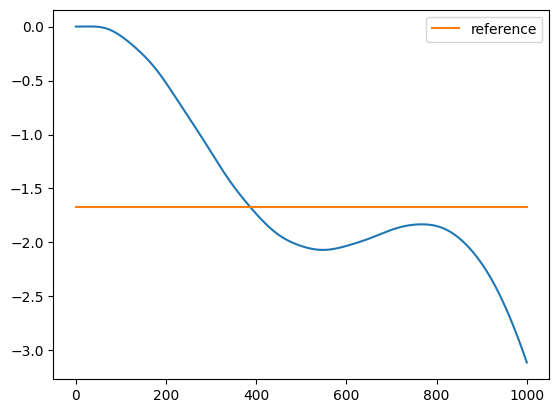

In [13]:
import matplotlib.pyplot as plt 

i = 5
plt.plot(controller_performance_sample.obs["obs"]["xpos_of_segment_end"][i])
plt.plot(controller_performance_sample.obs["ref"]["xpos_of_segment_end"][i], label="reference")
plt.legend()